In [1]:
import networkx as nx
import pygraphviz as pgv
import IPython.display
import inspect
import copy
from solarized_light import *
def SLICE(G, node, loadname, line):
    storename=f'{loadname}({line})'
    succ=next(G.successors(node))
    G.add_node(storename, **DBSTORE)
    G.add_node(loadname, **DBLOAD)
    G.add_edge(node, storename)
    G.add_edge(loadname, succ)
    G.remove_edge(node, succ)

def costlegend(graph):
    graph.add_node('PYSTORE(LINE)', **PYSTORE)
    graph.add_node('DBSTORE(LINE)', **DBSTORE)
    graph.add_node('PYLOAD' , **PYLOAD)
    graph.add_node('OPERATOR', **OPERATOR)
    graph.add_node('DBLOAD', **DBLOAD)
    graph.add_node('ACTION')

    graph.add_edge('DBSTORE(LINE)','PYSTORE(LINE)', style='invis')
    graph.add_edge('DBSTORE(LINE)','OPERATOR', style='invis')
    graph.add_edge('OPERATOR','DBLOAD', style='invis')
    graph.add_edge('DBLOAD','PYLOAD', style='invis')
    graph.add_edge('PYLOAD','ACTION', style='invis')
    graph.add_subgraph(['PYSTORE(LINE)','PYLOAD','DBLOAD','OPERATOR','DBSTORE(LINE)', 'ACTION'], name='cluster_legend', label='Legend')
    return graph

def nolegend(graph):
    return graph

def showgraph(graph, addlegendf=nolegend, *args, **kwargs):
    if nx.classes.graph.Graph in inspect.getmro(type(graph)):
        graph = nx.nx_agraph.to_agraph(graph)
    
    graph=addlegendf(graph)
    graphimage = graph.draw(format='png', prog='dot')
    return IPython.display.Image(graphimage, *args, **kwargs)


#showgraph(legend)

#Symbols PROJ SEL ρ JOIN θ ⋉ ⋊ ▷

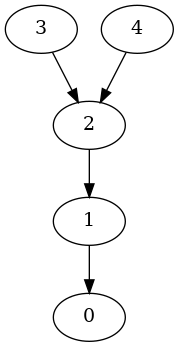

In [2]:
D = nx.gn_graph(5)
showgraph(D)

In [3]:
SLICE(D, 1, 'S', 4)

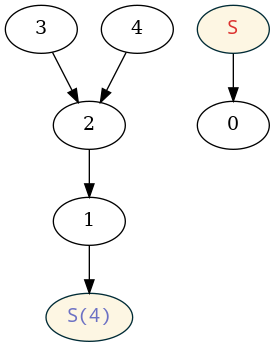

In [4]:
showgraph(D)

# Assumptions

We can make some useful assumptions about the programs we will optimize, but we have to be aware about the limitations of those assumptions. The following snippets demonstrate cases where our assumptions would break the input program.

```python
# wflow.py
b=pd.read_sql('SELECT * FROM ...') # only rel.alg will be applied to b
c=b.loc[,'col1']
action(c)
```

```python
# aggressive.py
c=pd.read_sql('SELECT col1 FROM ...')
action(c)
```

Interactivity is a very useful feature in Python. Our optimizer just broke it.
```bash
$ python3 -i aggressive.py
```
```python
>>> b
NameException
```

### "Careful" Optimization

```python
# careful.py
b=pd.read_sql('SELECT * FROM ...')
c=pd.read_sql('SELECT col1 FROM ...')
action(c)
```

1. Slower than the aggressive optimization, but doesn't break interactivity.
2. Might even be slower than the original. We need to estimate costs

```bash
$ python3 -i careful.py
```
```python
>>> b
[some data]
```


### Questions
1. Is this an interesting thing to mention in the thesis? Do scientist care about this?

# Optimizing Forks

```python
# wflow.py
x=pd.read_sql('SELECT * FROM X')
y=pd.read_sql('SELECT * FROM Y')
j=a.merge(b) #costly inner join
action(j)
p=j.loc[,'col1'] # Projection
action(p)

# action(j) and the Projection form a Fork
```

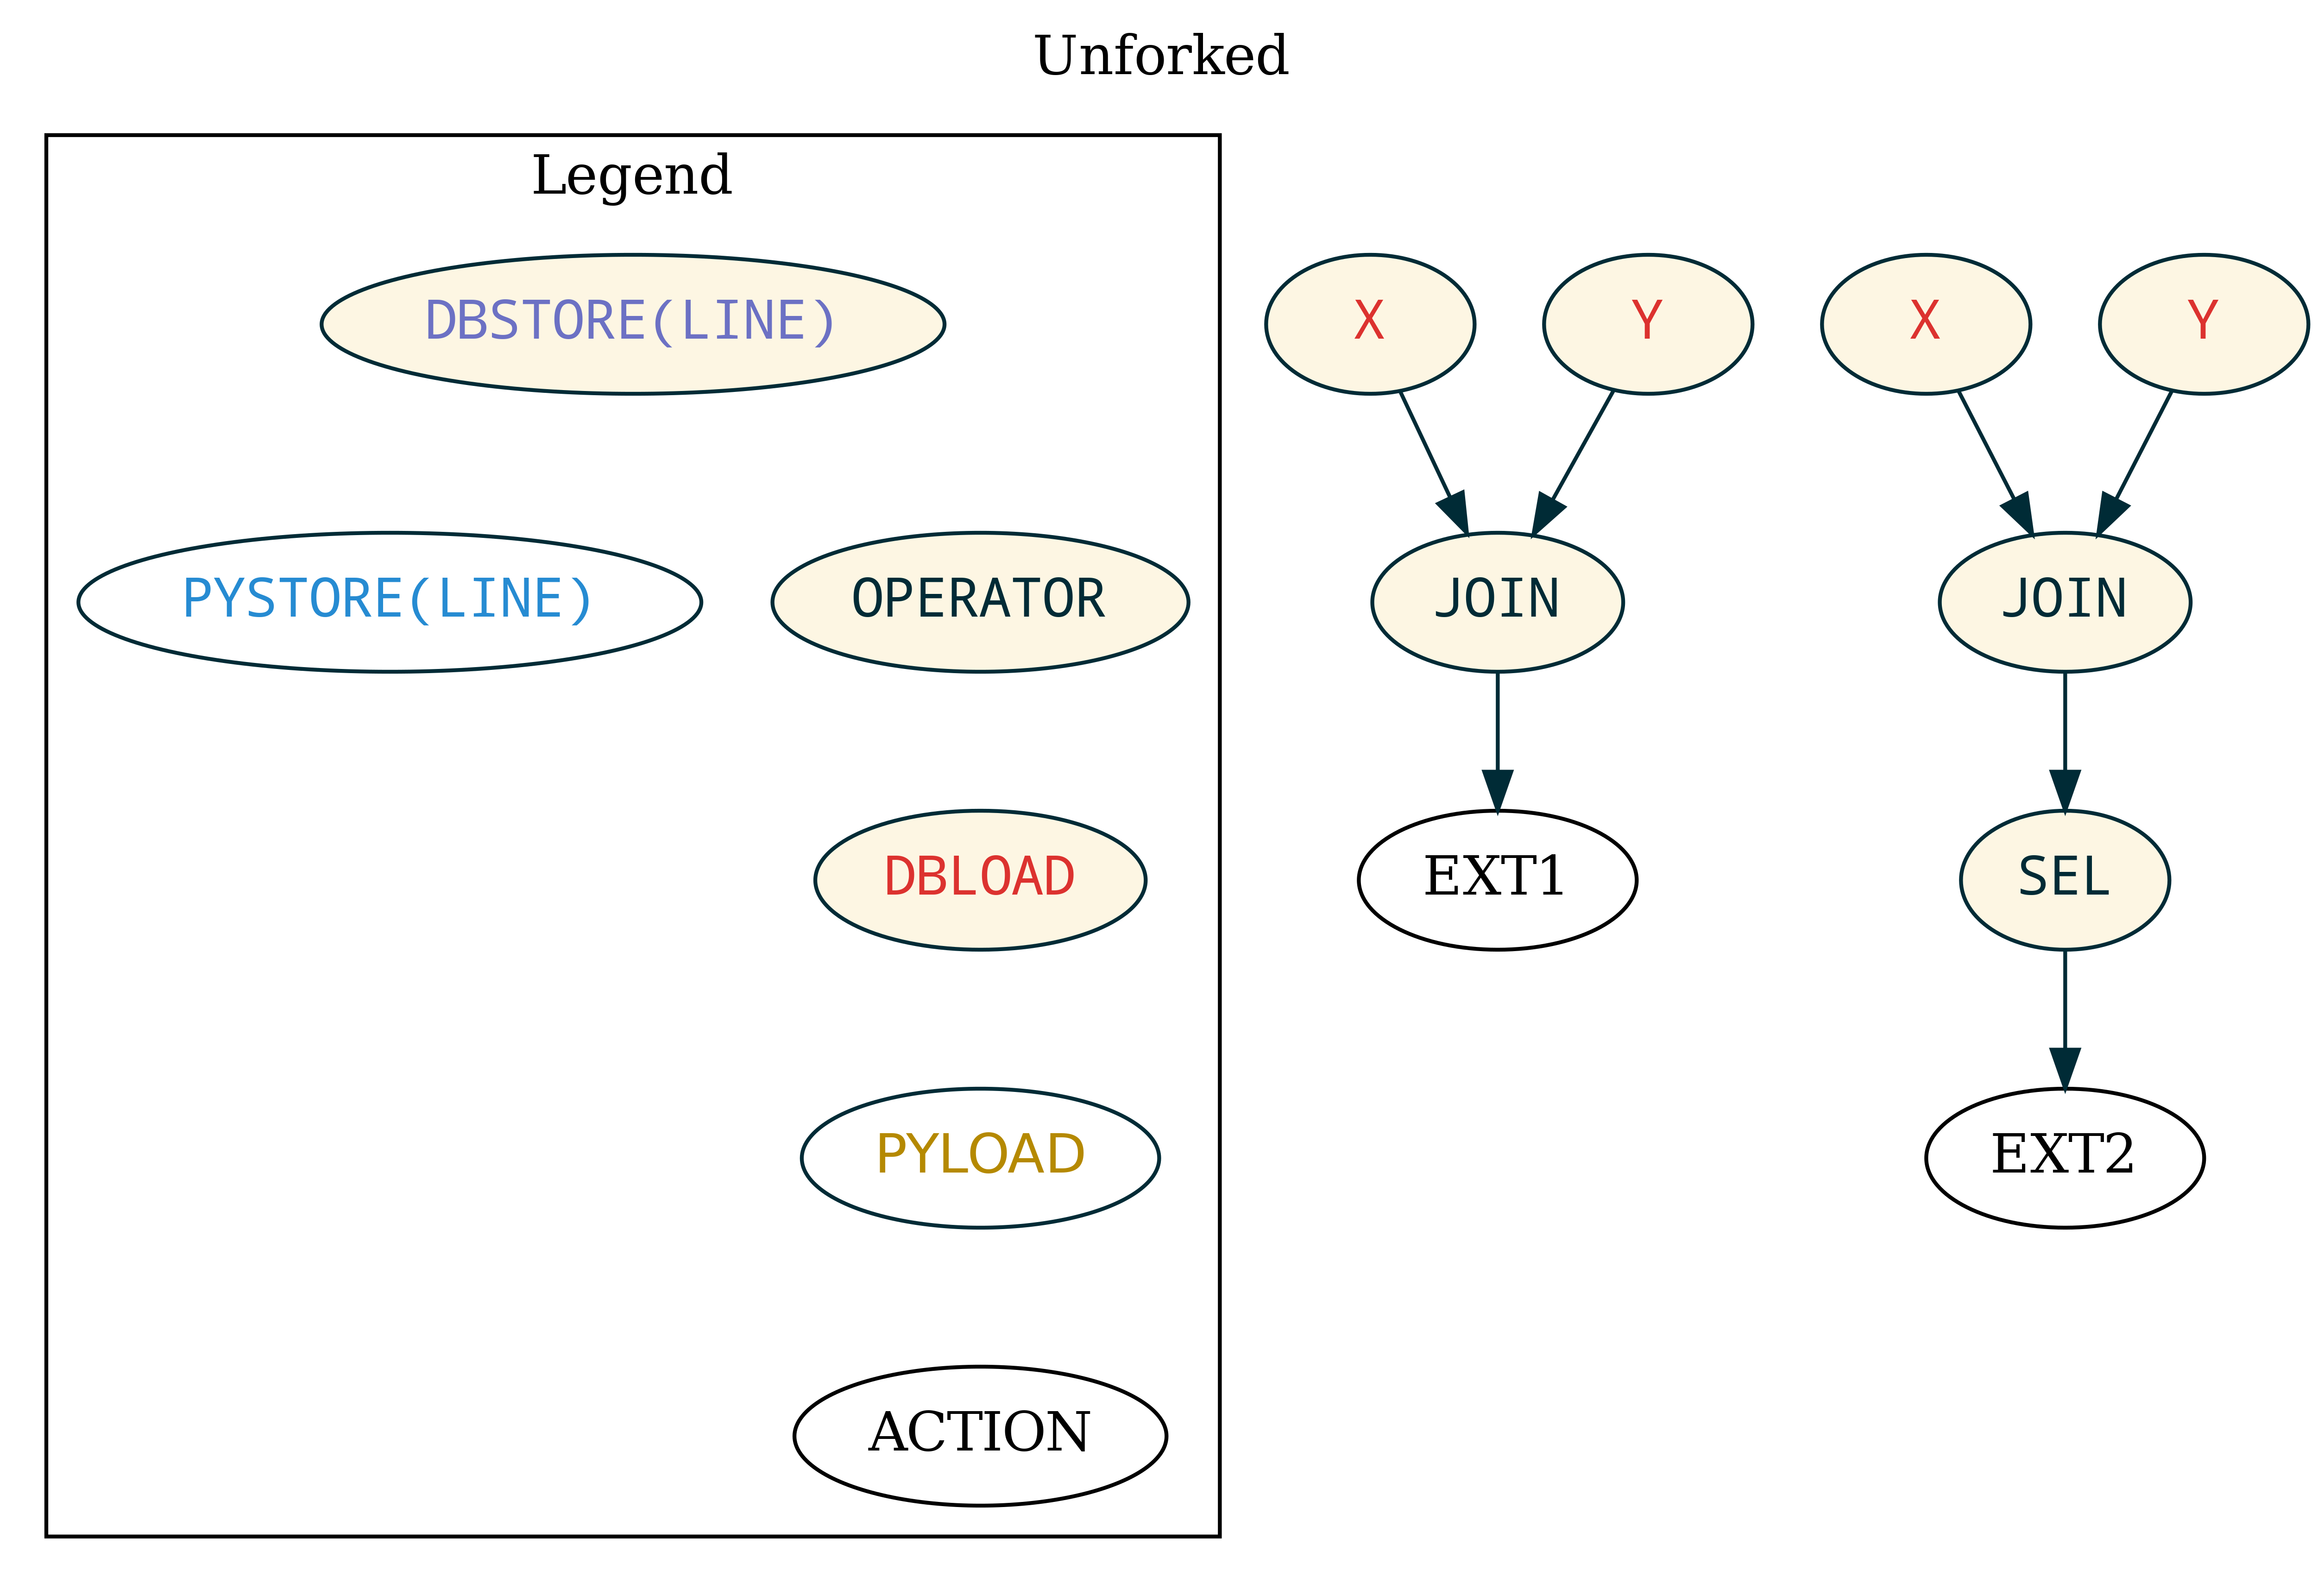

In [5]:
FORK = nx.DiGraph(dpi=600, labelloc='t', label='Unforked', layout='dot')

FORK.add_node('X(1)',label='X', **DBLOAD)
FORK.add_node('Y(1)',label='Y', **DBLOAD)
FORK.add_node('JOIN(1)',label='JOIN', **OPERATOR)
FORK.add_node('X(2)',label='X', **DBLOAD)
FORK.add_node('Y(2)',label='Y', **DBLOAD)
FORK.add_node('JOIN(2)',label='JOIN', **OPERATOR)
FORK.add_node('SEL', **OPERATOR)
FORK.add_node('EXT1')
FORK.add_node('EXT2')

FORK.add_edge('X(1)', 'JOIN(1)',color=C_BLACK)
FORK.add_edge('Y(1)', 'JOIN(1)',color=C_BLACK)
FORK.add_edge('JOIN(1)', 'EXT1',color=C_BLACK)
FORK.add_edge('X(2)', 'JOIN(2)',color=C_BLACK)
FORK.add_edge('Y(2)', 'JOIN(2)',color=C_BLACK)
FORK.add_edge('JOIN(2)', 'SEL',color=C_BLACK)
FORK.add_edge('SEL', 'EXT2',color=C_BLACK)

showgraph(FORK, costlegend, width=800)

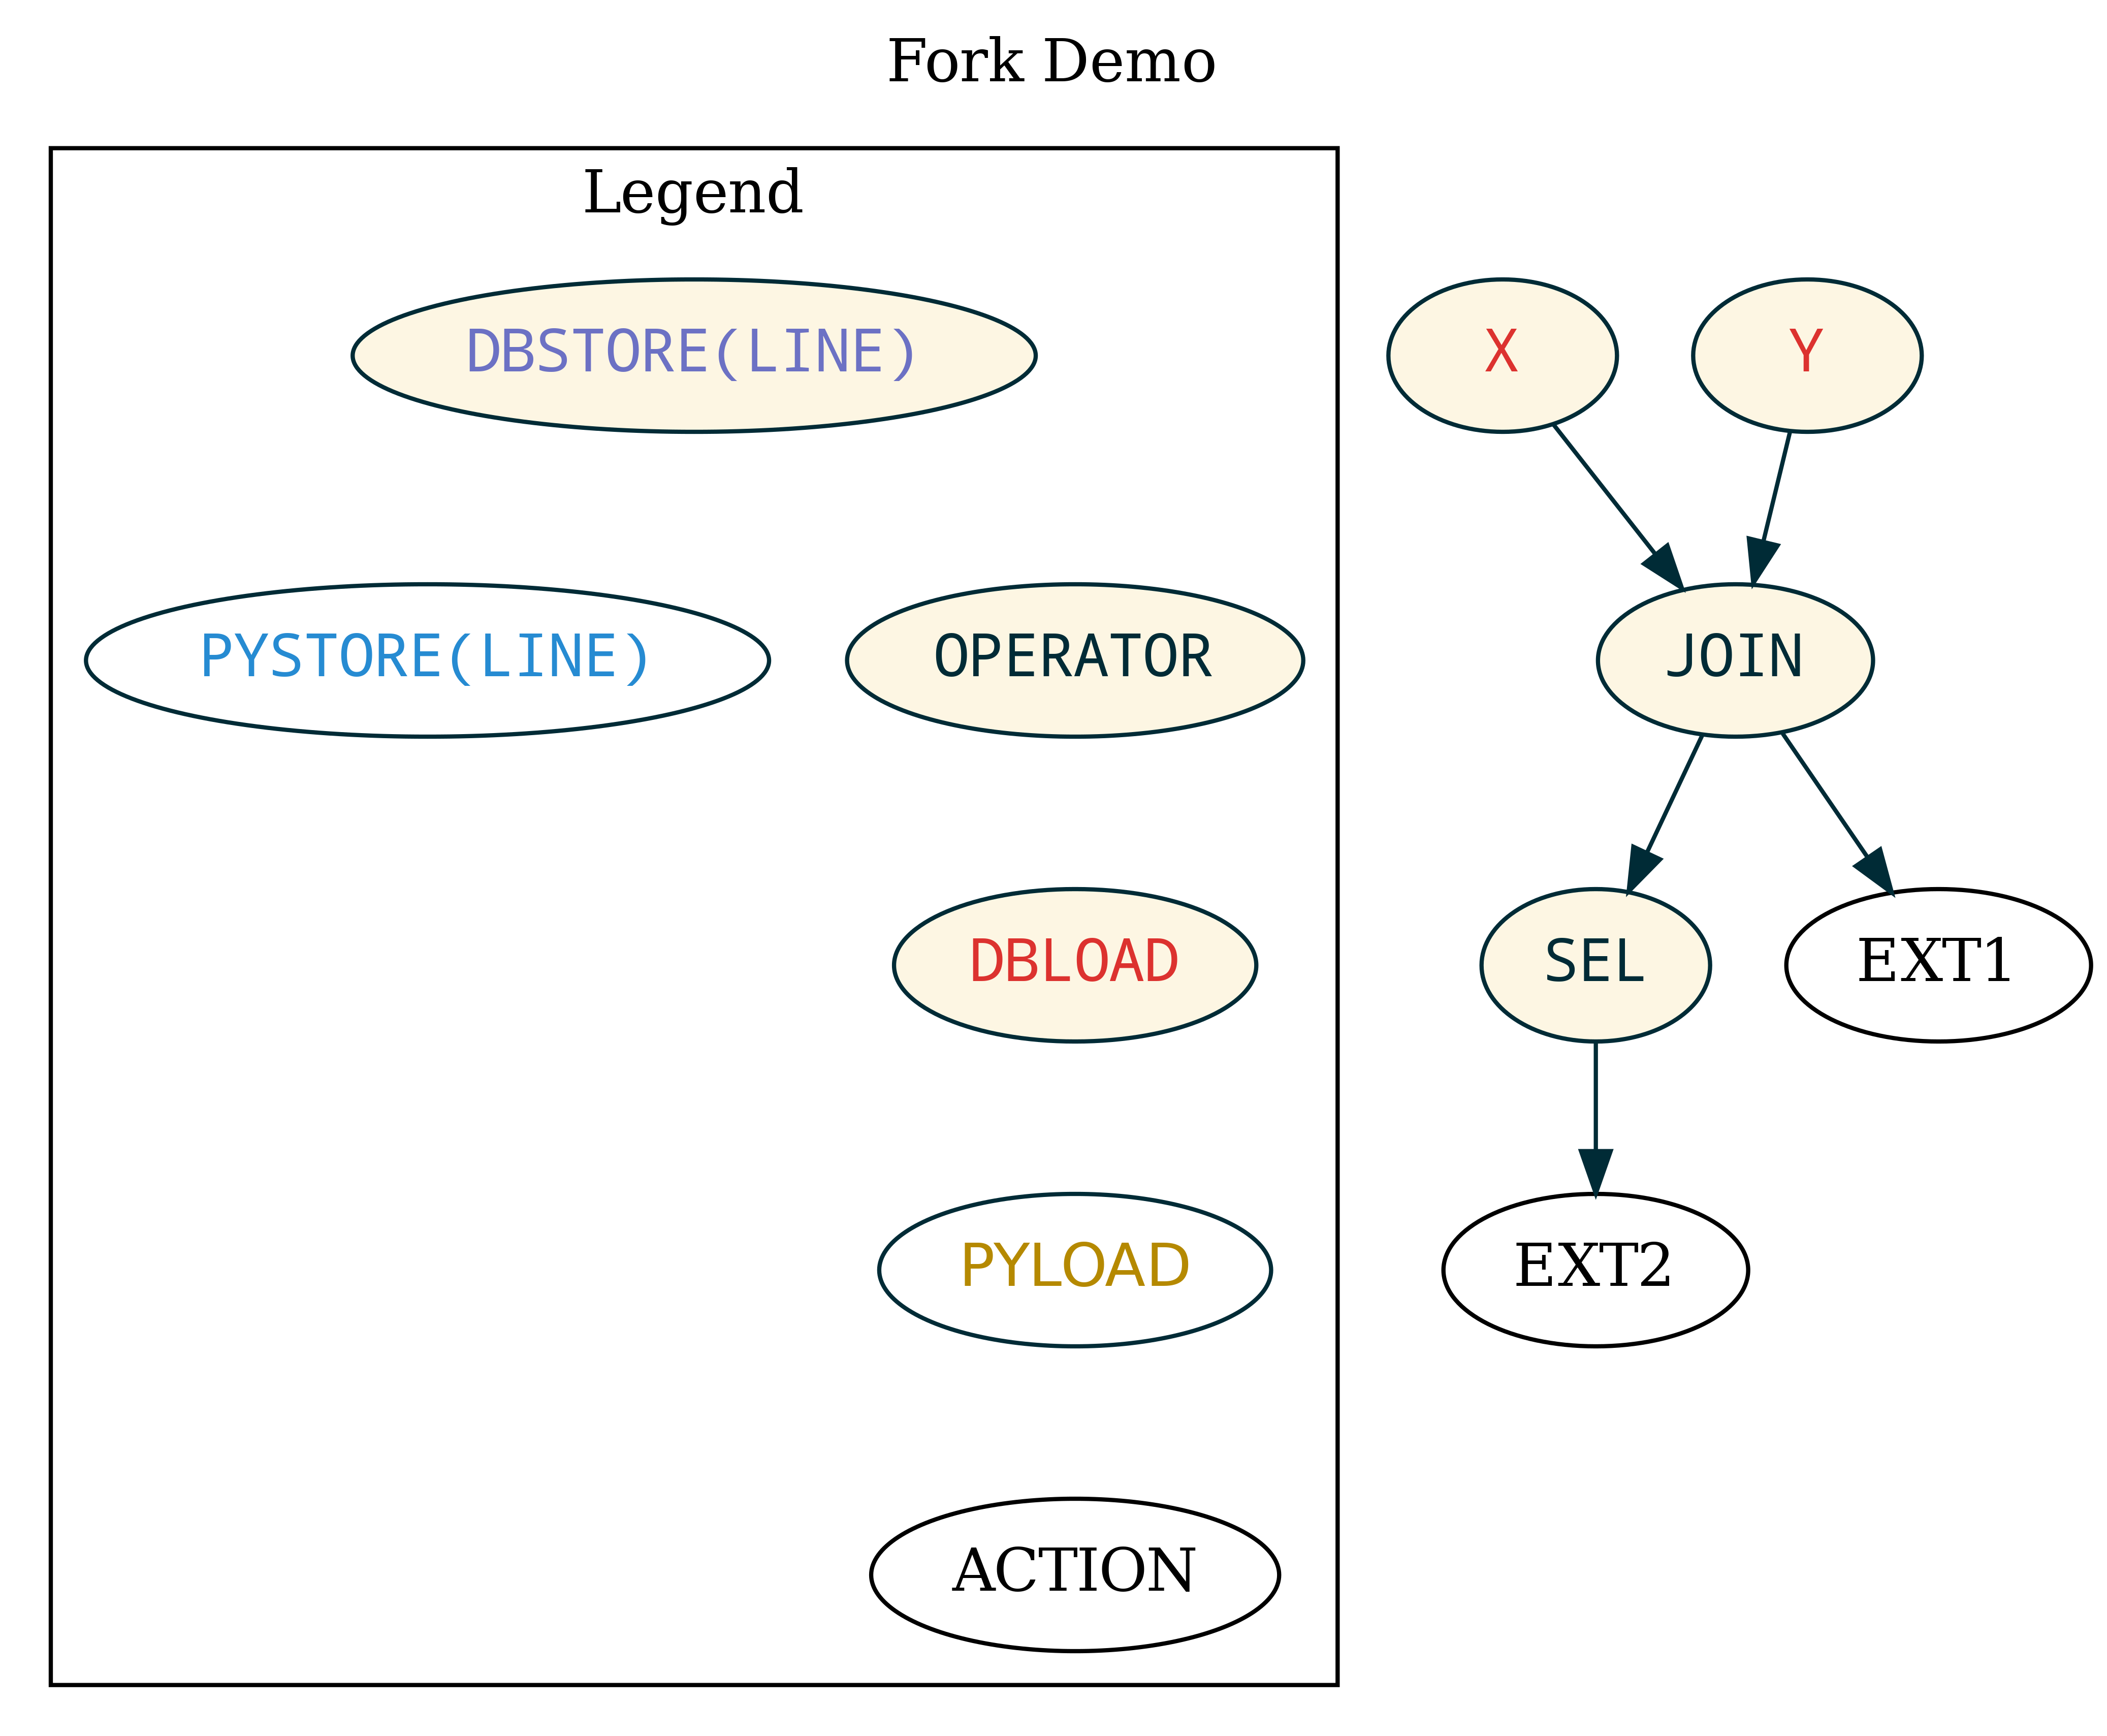

In [6]:
FORK = nx.DiGraph(dpi=600, labelloc='t', label='Fork Demo', layout='dot')

FORK.add_node('X', **DBLOAD)
FORK.add_node('Y', **DBLOAD)
FORK.add_node('JOIN', **OPERATOR)
FORK.add_node('SEL', **OPERATOR)
FORK.add_node('EXT1')
FORK.add_node('EXT2')

FORK.add_edge('X', 'JOIN',color=C_BLACK)
FORK.add_edge('Y', 'JOIN',color=C_BLACK)
FORK.add_edge('JOIN', 'EXT1',color=C_BLACK)
FORK.add_edge('JOIN', 'SEL',color=C_BLACK)
FORK.add_edge('SEL', 'EXT2',color=C_BLACK)

showgraph(FORK, costlegend, width=800)

```python
# forked.py
conn.execute('CREATE TEMP TABLE J AS SELECT * FROM X INNER JOIN Y')
action(pd.read_sql('SELECT * FROM J'))
action(pd.read_sql('SELECT col1 FROM J'))
```

```python
# unforked.py
action(pd.read_sql('SELECT * FROM X INNER JOIN Y'))
action(pd.read_sql('SELECT col1 FROM X INNER JOIN Y'))
```

### My views
- The **forked** version treats the RDBMS as a stupid system, which it is not.
- the **forked** version depends on disk IO speed because it creates a new table. Right?
- The **unforked** version has a duplicate computation and the RDBMS is left alone to decide what to cache. But how would it know to cache the join specifically?
- Perhaps this could best be tackled with **cost-based optimization**\?

### Questions

- Is one approach always better than the other?
- Is it worth it to go in this direction?
- Even if I don't implement this, would it be OK to discuss it in the thesis?

Side note: if we go for the special handling of forks, we will be working with **Directed Acyclic Graphs** instead of tree

# Adding unsupported nodes to the equation (intermediate Actions)

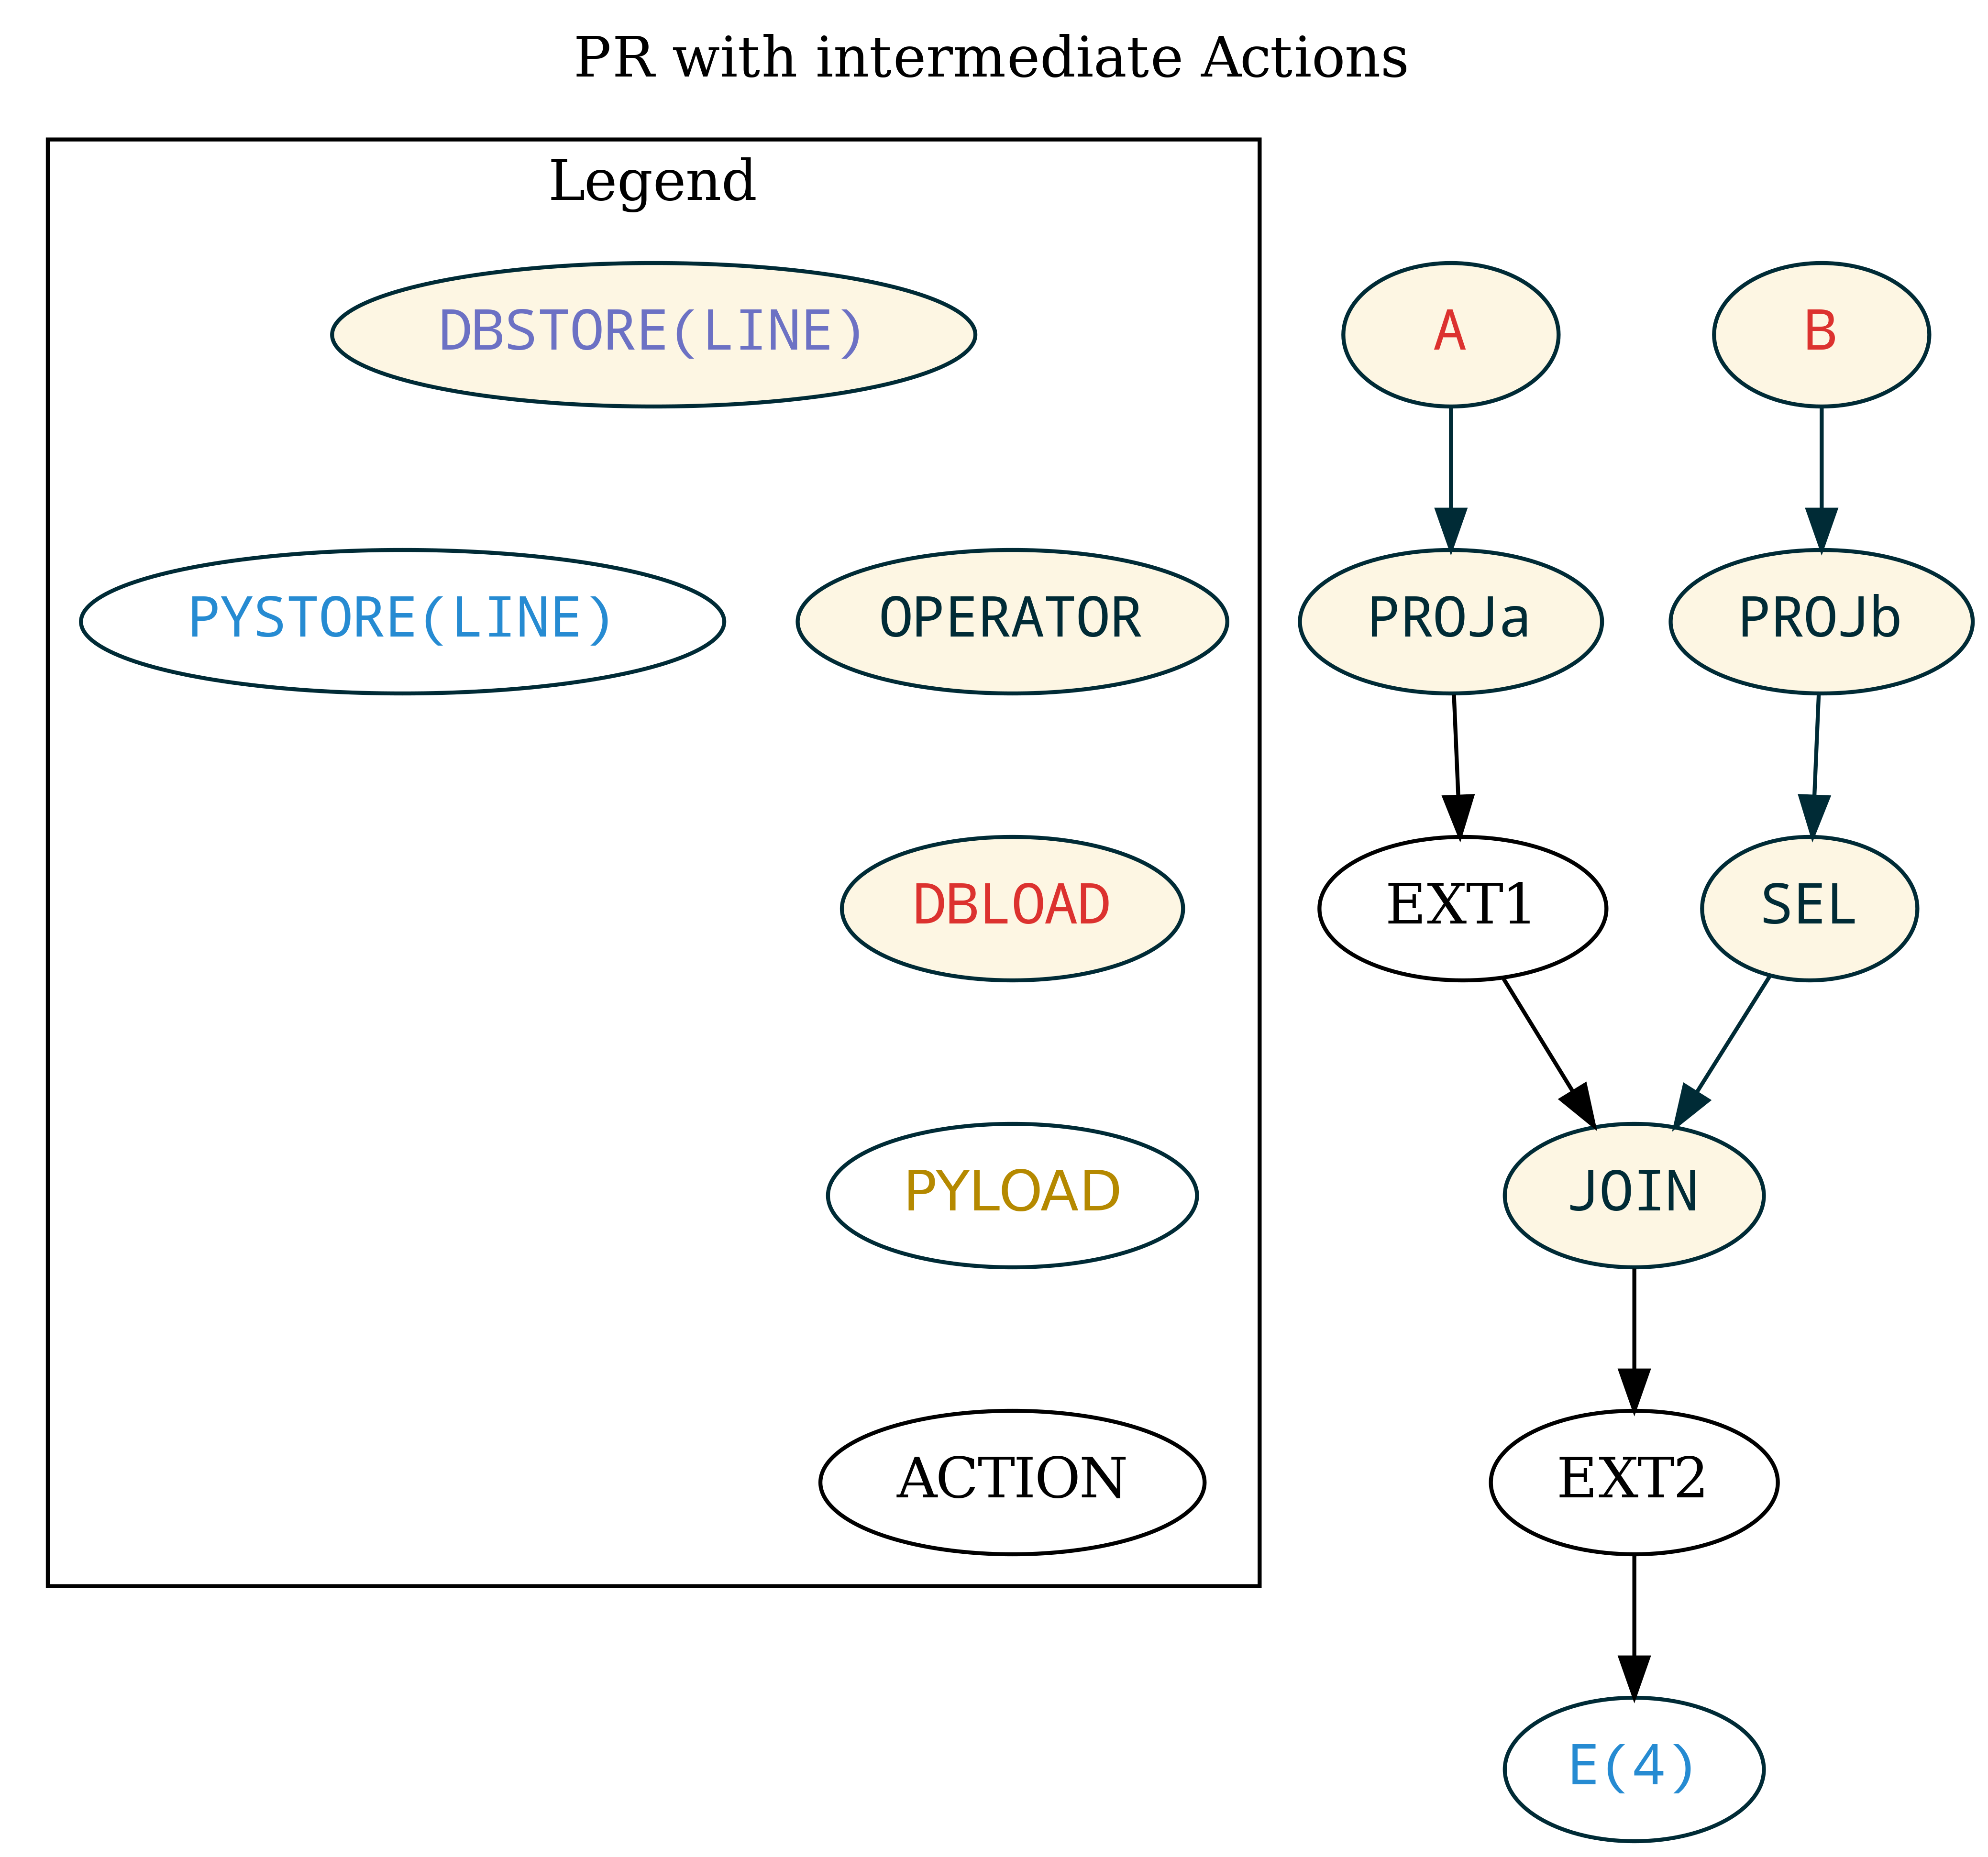

In [12]:
PRiA = nx.DiGraph(dpi=600, labelloc='t', label='PR with intermediate Actions', layout='dot')

PRiA.add_node('A', **DBLOAD)
PRiA.add_node('B', **DBLOAD)
PRiA.add_node('E(4)', **PYSTORE)
PRiA.add_node('PROJb', **OPERATOR)
PRiA.add_node('JOIN', **OPERATOR)
PRiA.add_node('PROJa', **OPERATOR)
PRiA.add_node('SEL', **OPERATOR)

PRiA.add_edge('A', 'PROJa',color=C_BLACK)
PRiA.add_edge('B', 'PROJb',color=C_BLACK)
PRiA.add_edge('PROJb', 'SEL',color=C_BLACK)
PRiA.add_edge('SEL', 'JOIN',color=C_BLACK)


PRiA.add_node('EXT1')
PRiA.add_edge('EXT1','JOIN')
PRiA.add_edge('PROJa','EXT1')

PRiA.add_node('EXT2')
PRiA.add_edge('JOIN','EXT2')
PRiA.add_edge('EXT2','E(4)')

showgraph(PRiA, costlegend, width=700)



Round brackets:
\begin{pmatrix}
E1 & E2\\
\xi &
\end{pmatrix}


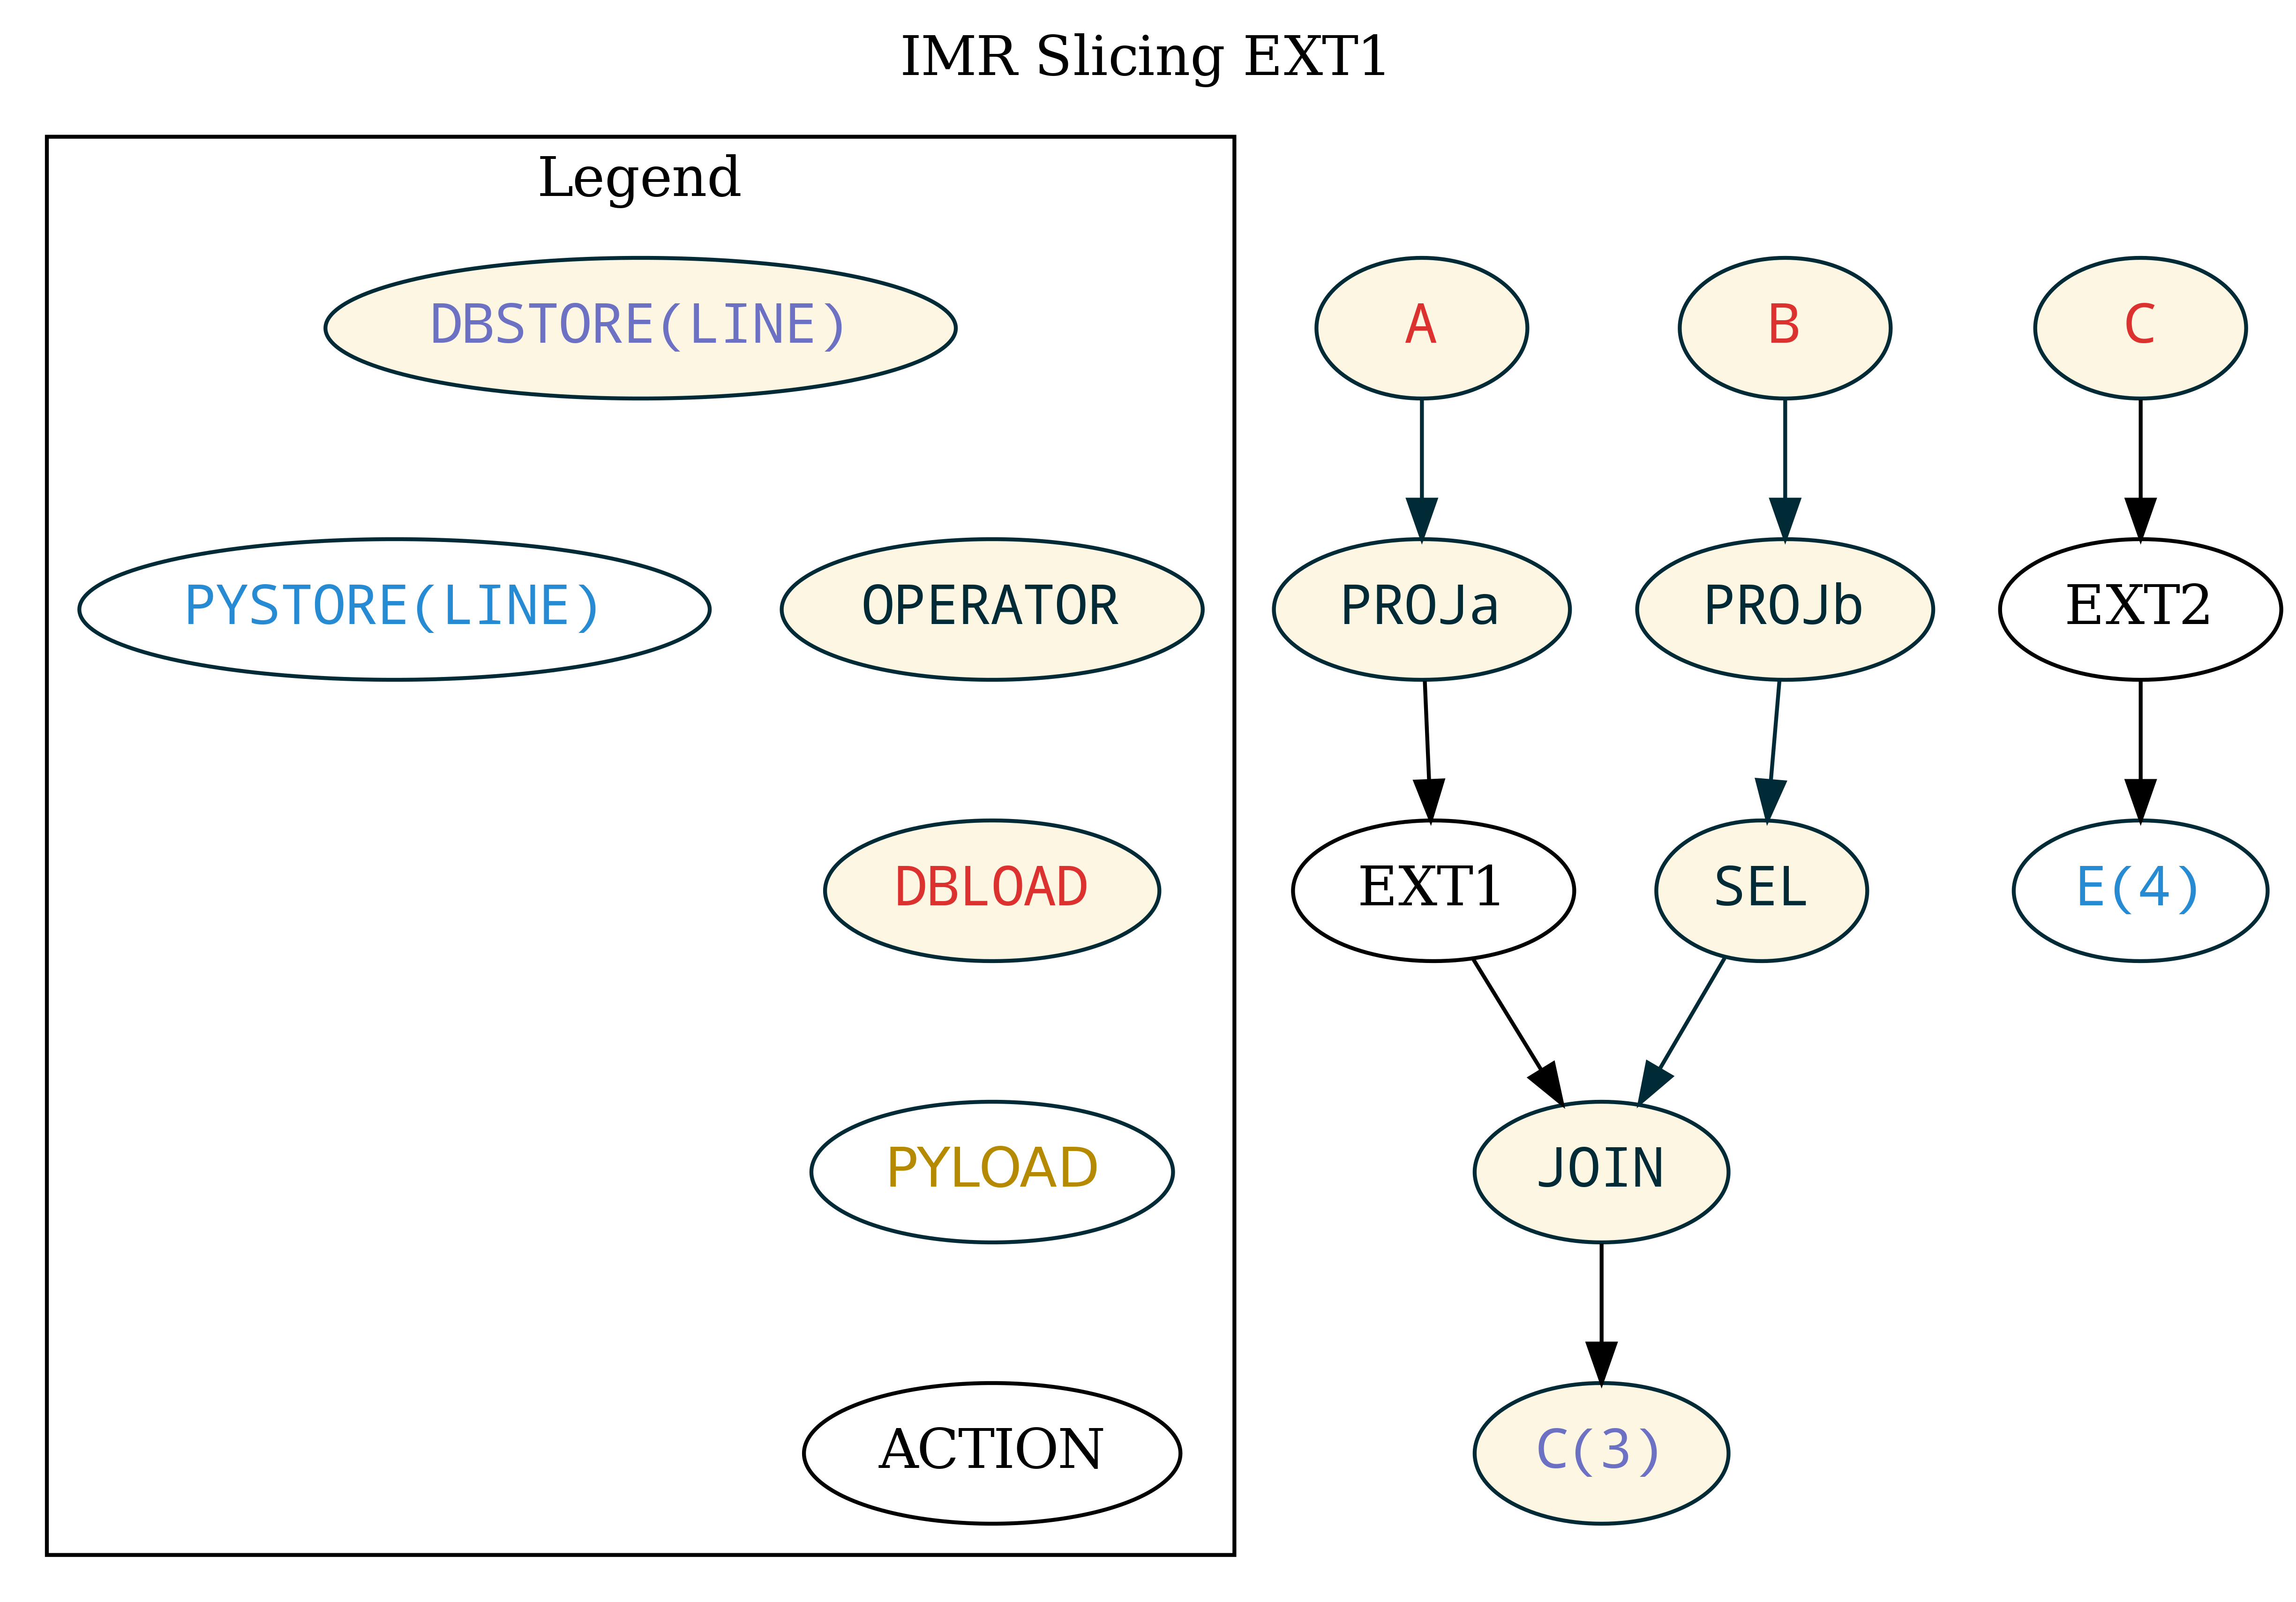

In [13]:
SLICE1=copy.deepcopy(PRiA)
SLICE1.graph['label']='IMR Slicing EXT2'
SLICE(SLICE1, 'JOIN', 'C', 3)
showgraph(SLICE1, costlegend, width=800)

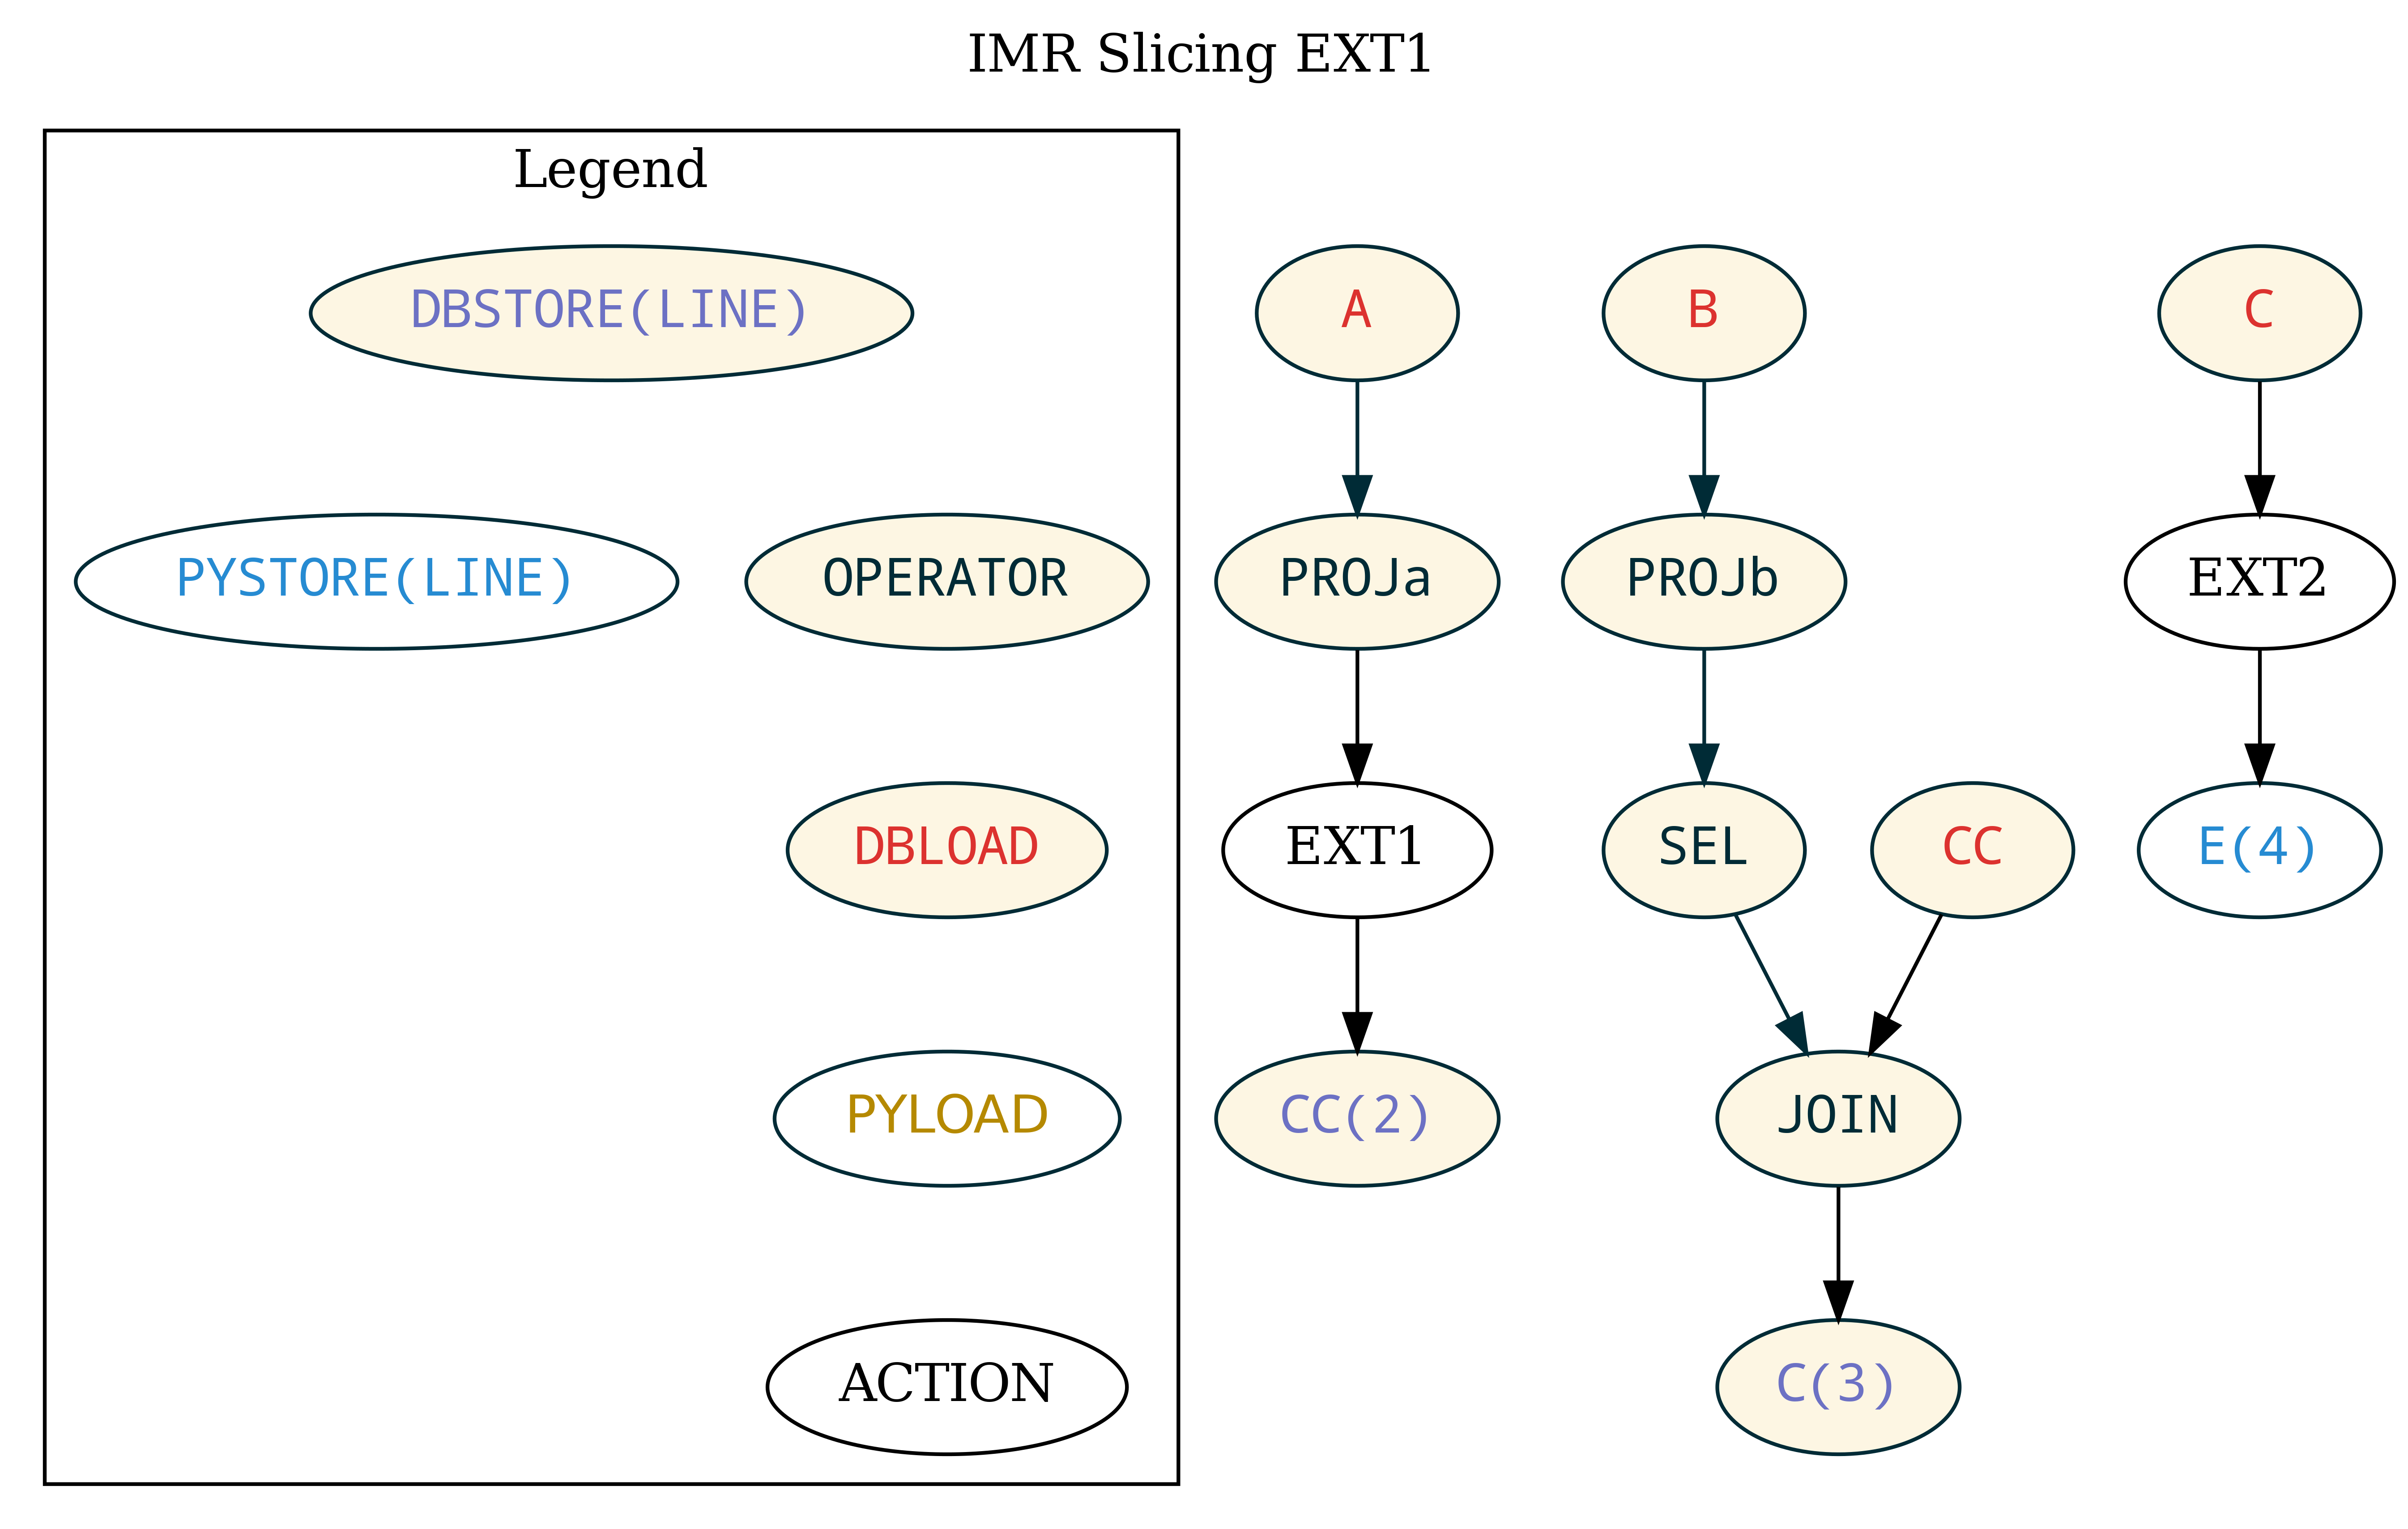

In [15]:
SLICE2=copy.deepcopy(SLICE1)
SLICE2.graph['label']='IMR Slicing EXT1'
SLICE(SLICE2, 'EXT1', 'CC', 2)
showgraph(SLICE2, costlegend, width=800)

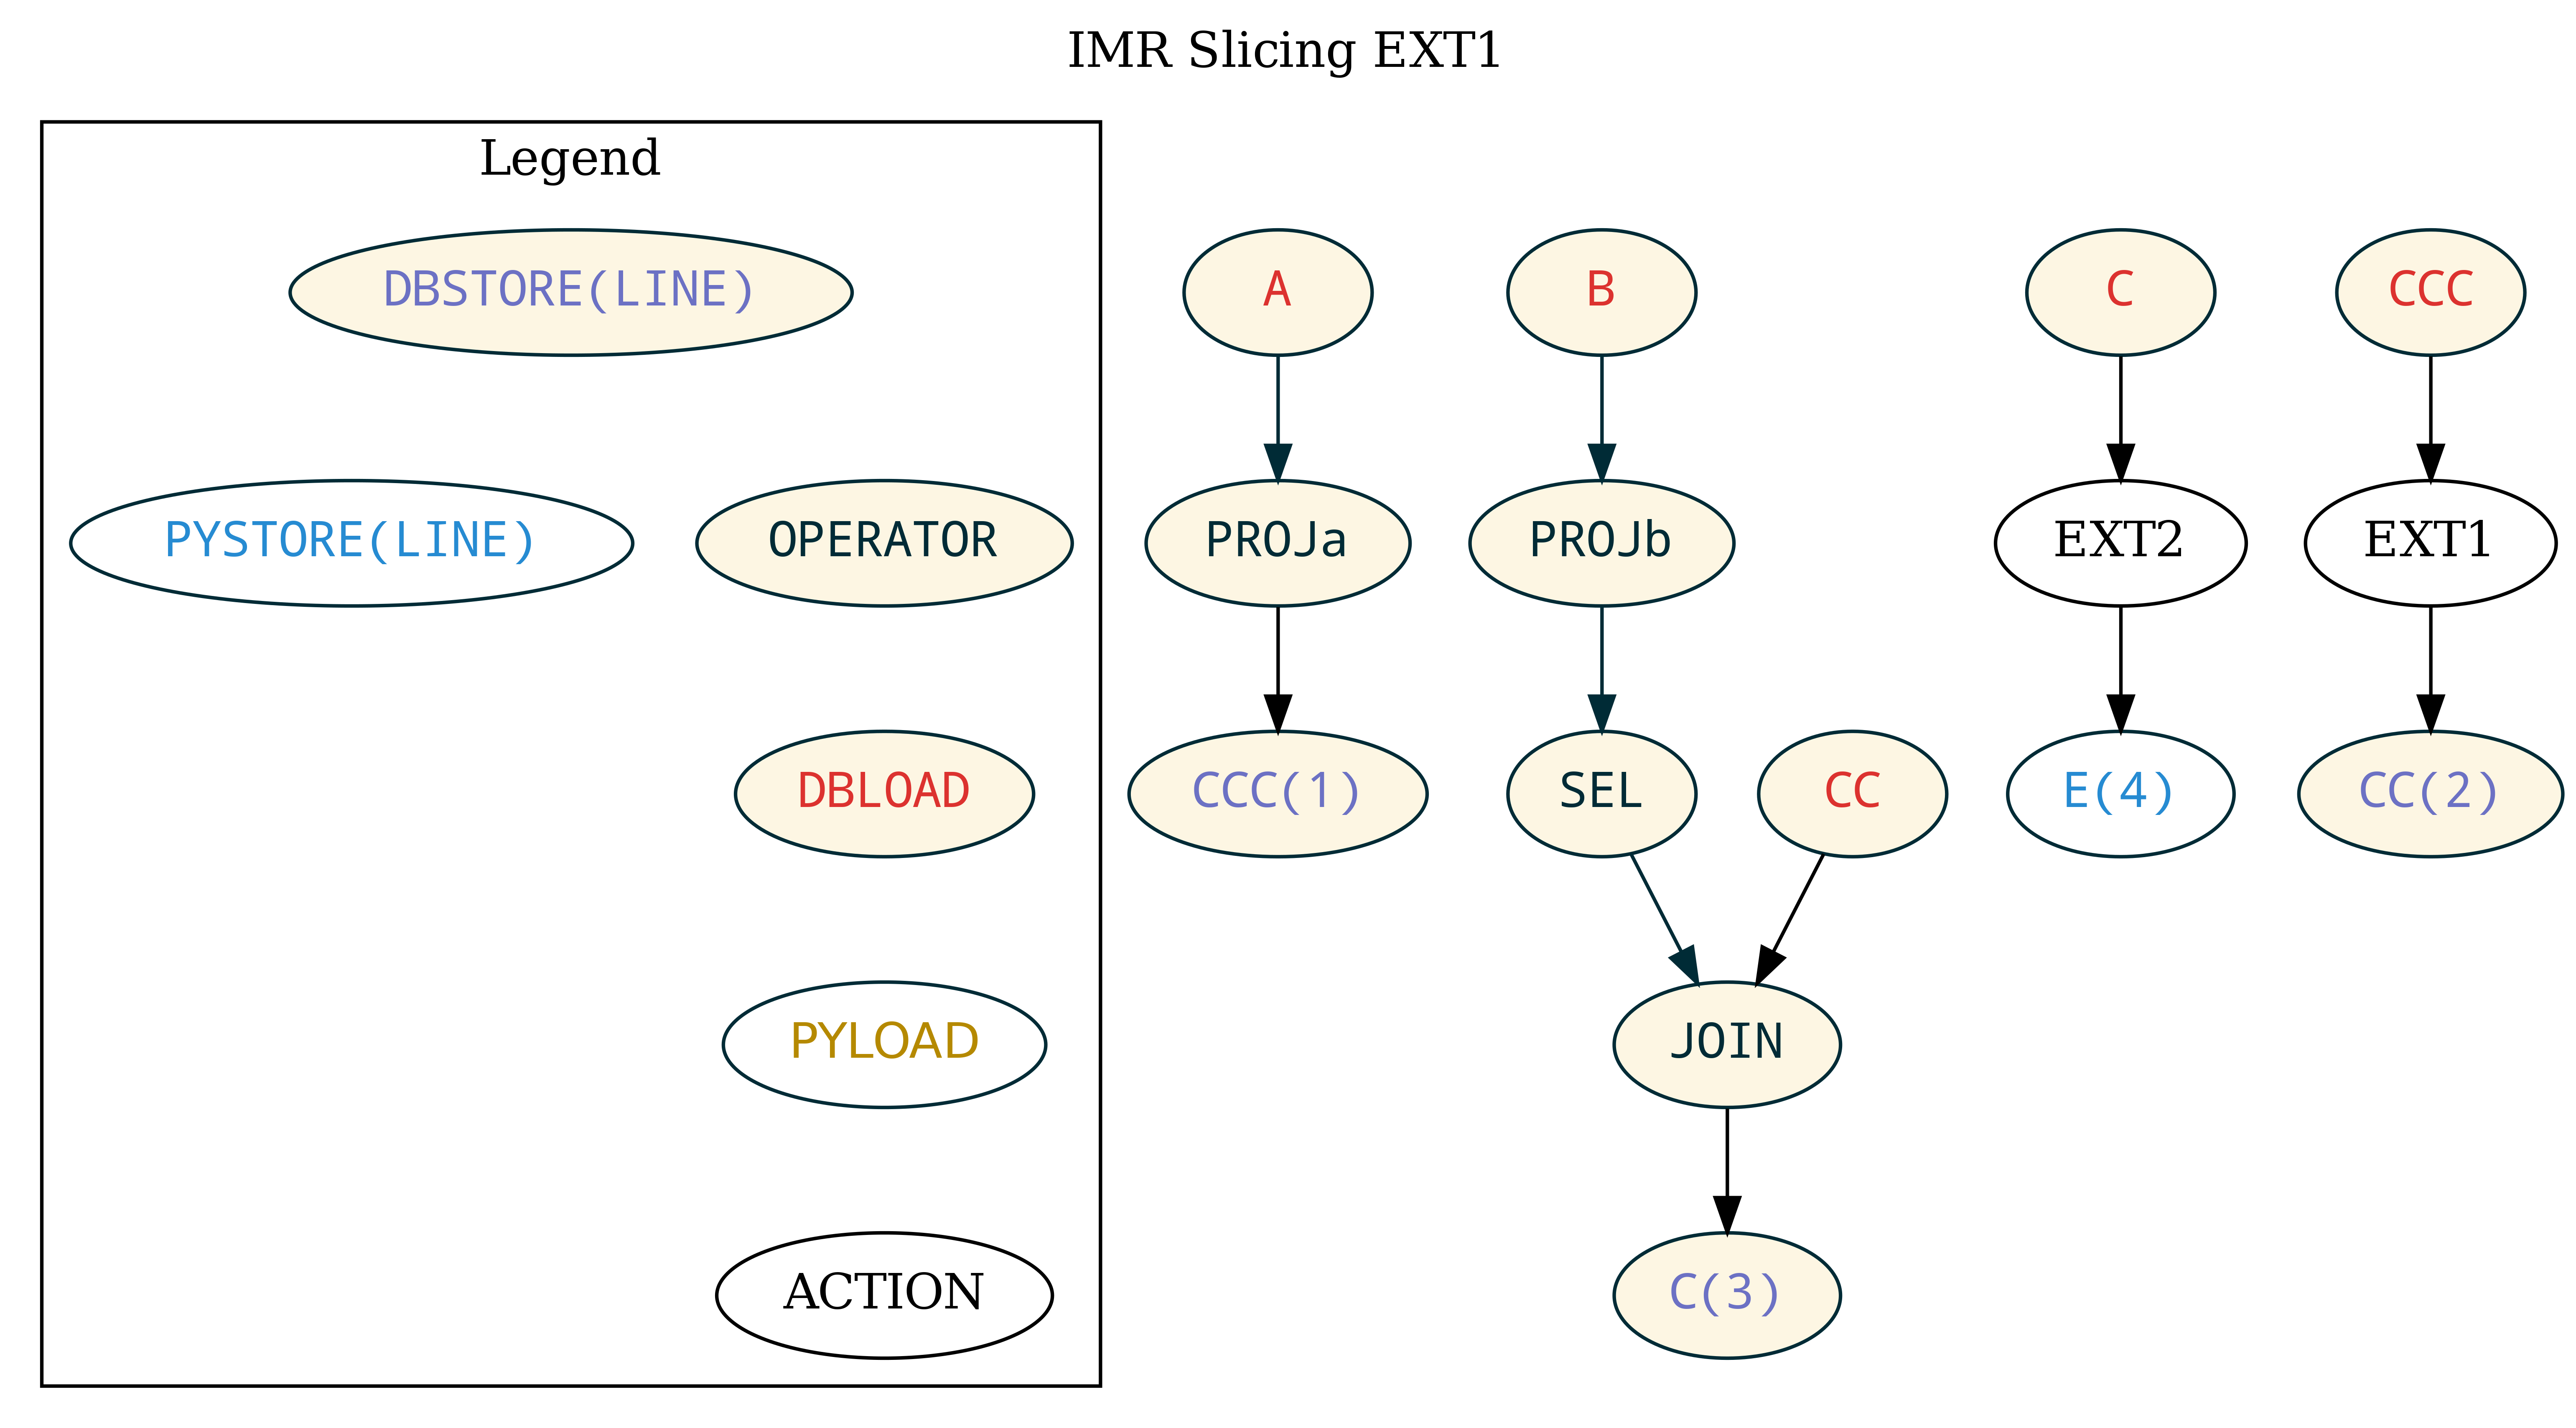

In [16]:
SLICE3=copy.deepcopy(SLICE2)
SLICE3.graph['label']='IMR Slicing EXT1'
SLICE(SLICE3, 'PROJa', 'CCC', 1)
showgraph(SLICE3, costlegend, width=800)

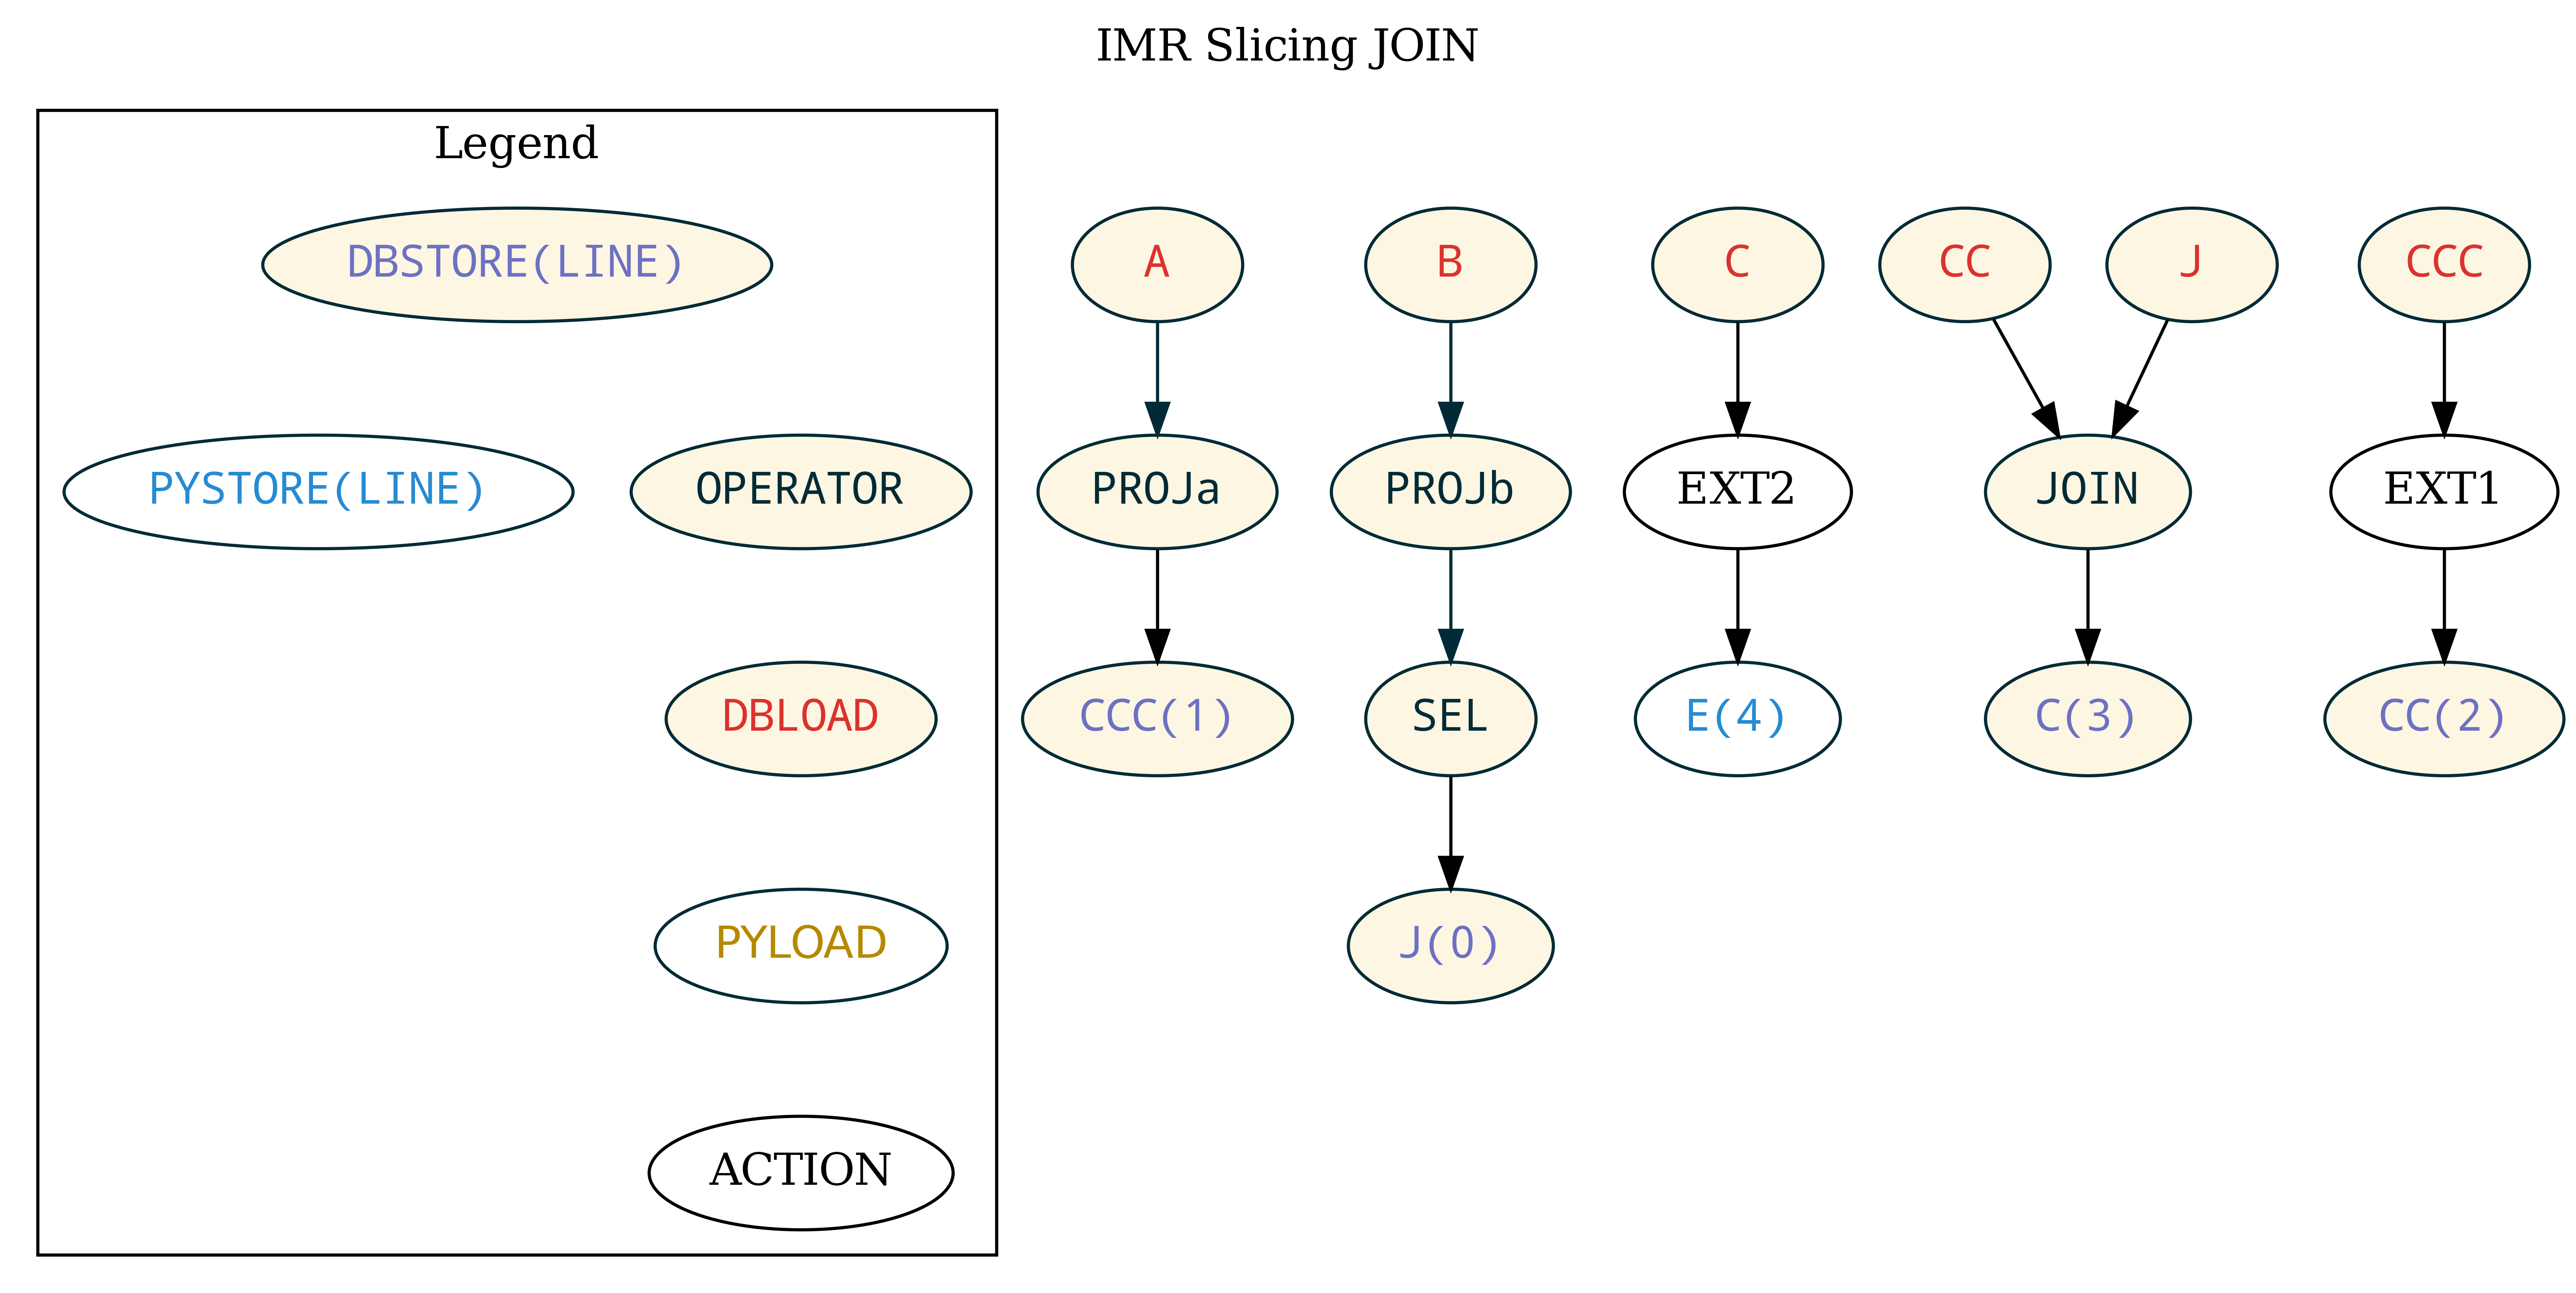

In [18]:
SLICEJ=copy.deepcopy(SLICE3)
SLICEJ.graph['label']='IMR Slicing JOIN'
SLICE(SLICEJ, 'SEL', 'J', 0)
showgraph(SLICEJ, costlegend, width=800)

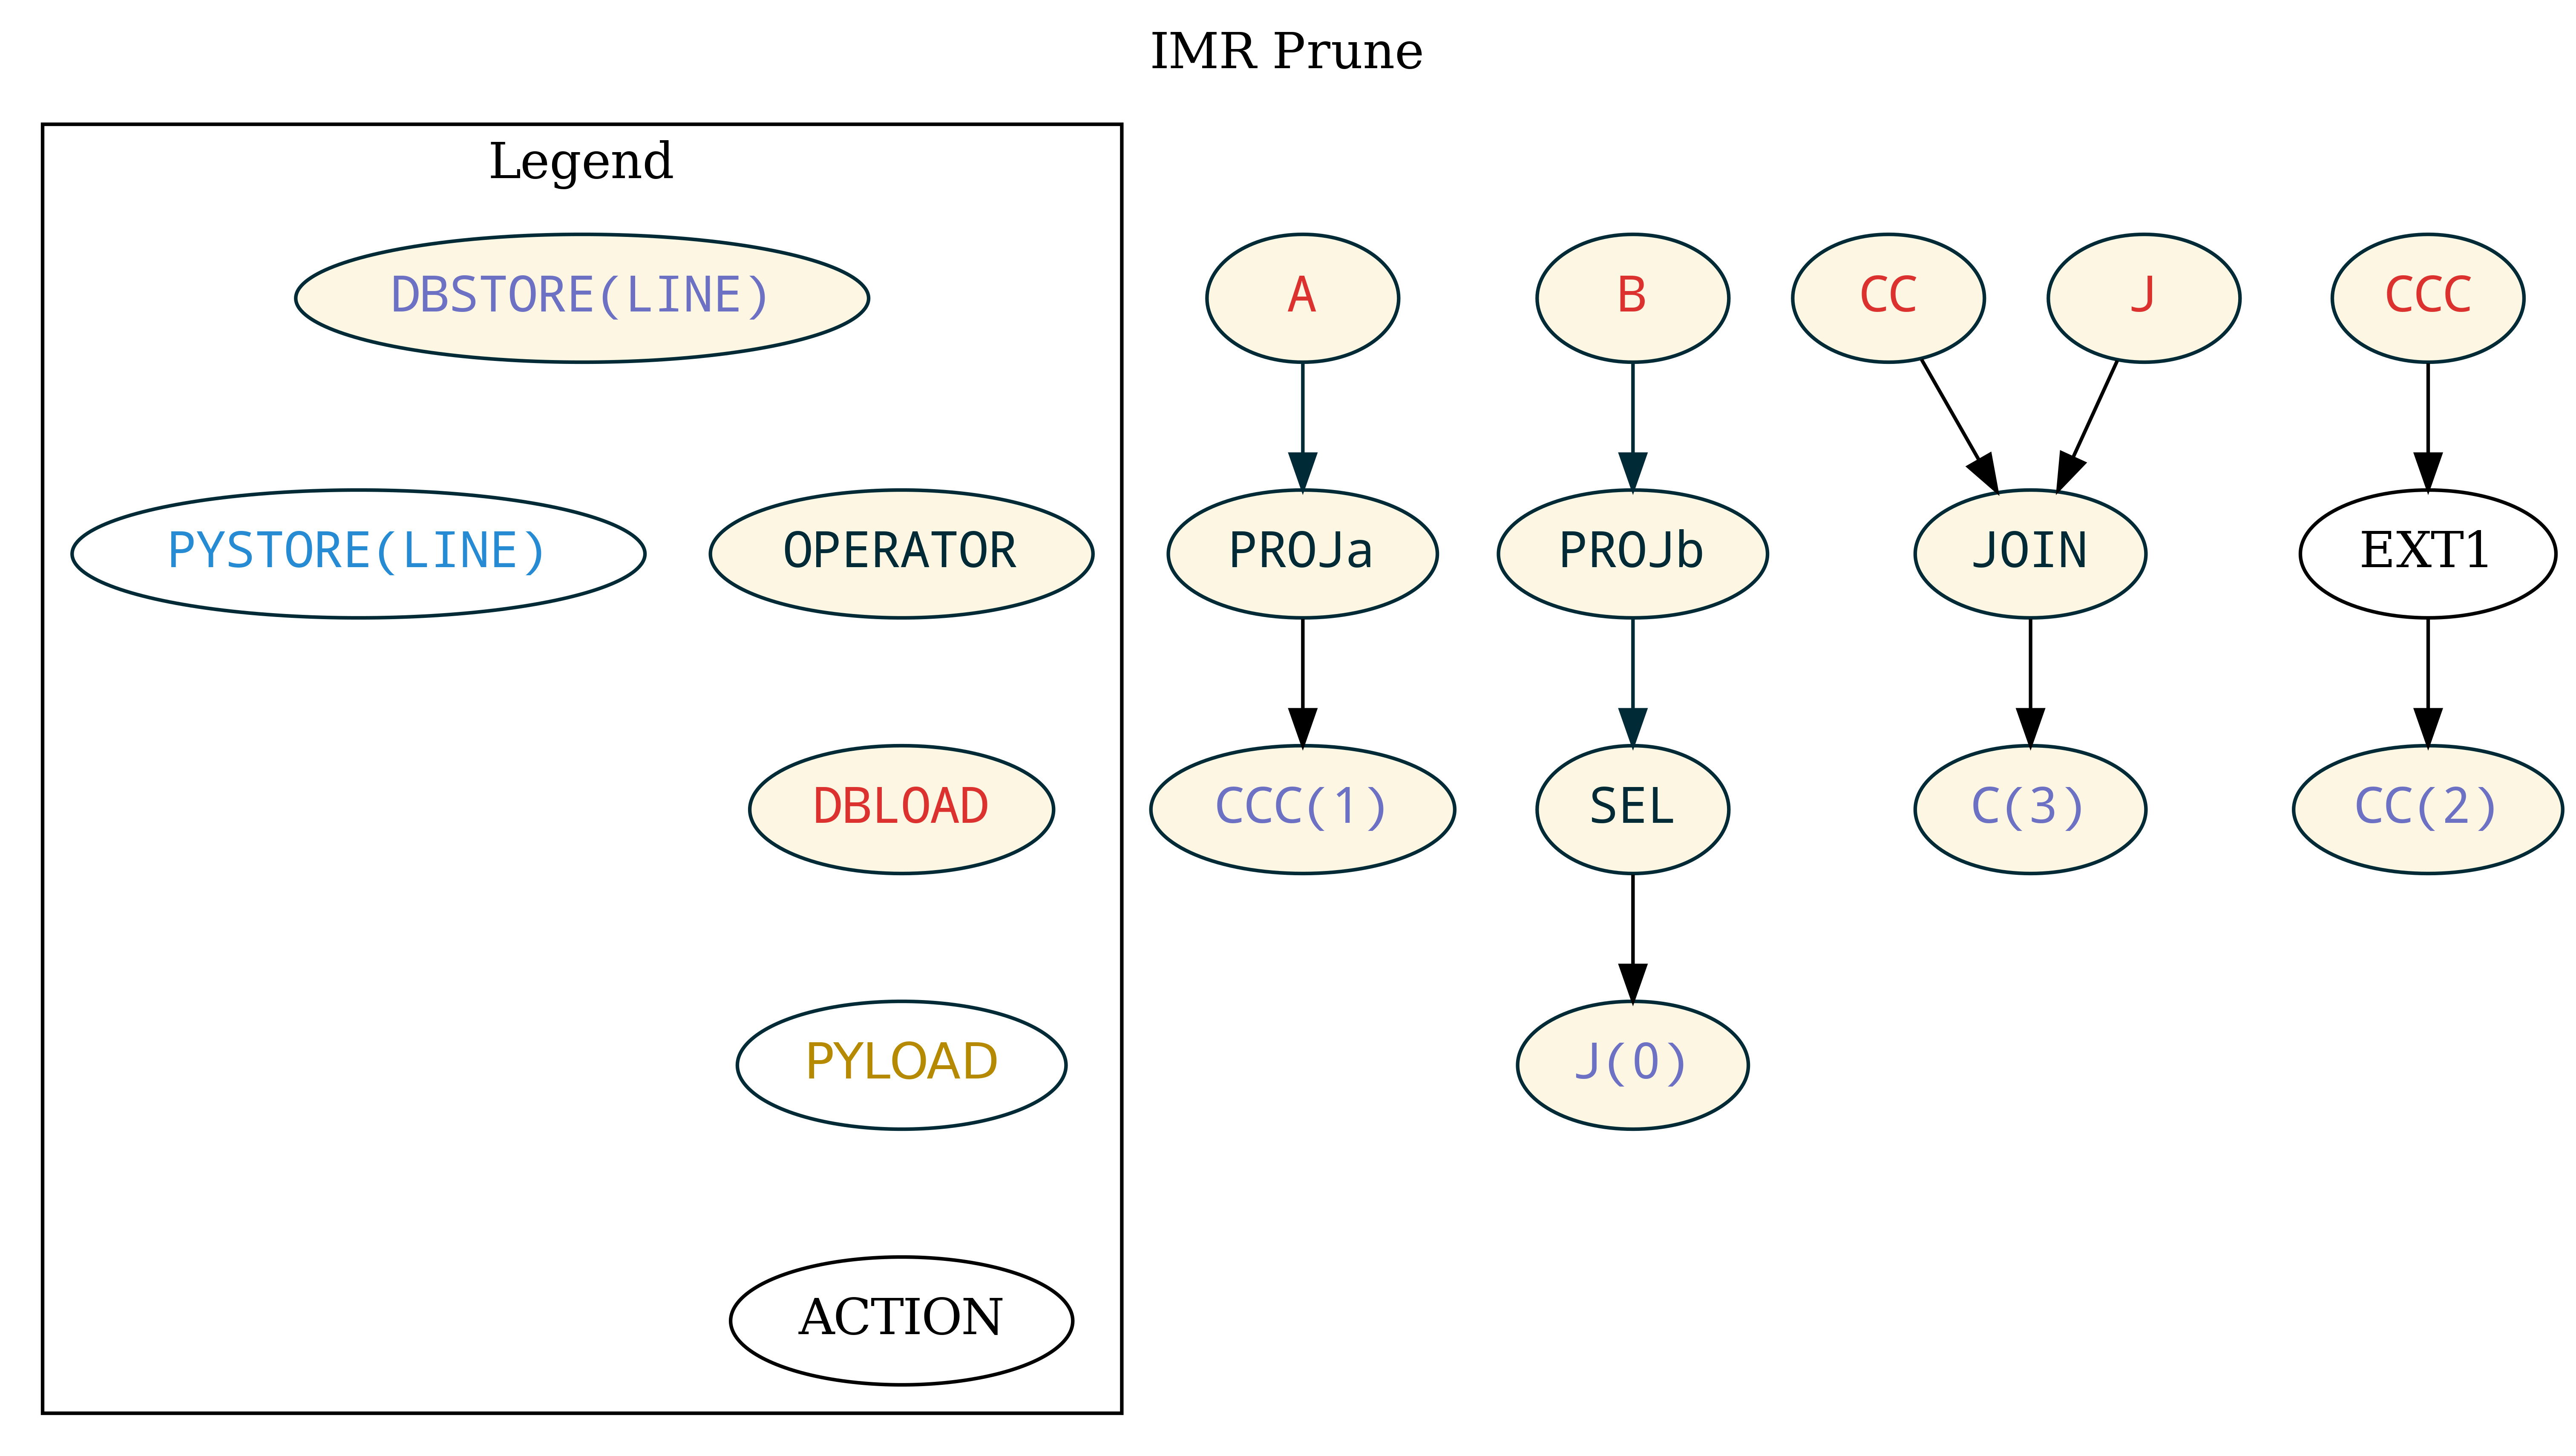

In [19]:
PRUNE=copy.deepcopy(SLICEJ)
PRUNE.graph['label']='IMR Prune'
PRUNE.remove_node('C')
PRUNE.remove_node('EXT2')
PRUNE.remove_node('E(4)')
showgraph(PRUNE, costlegend, width=800)

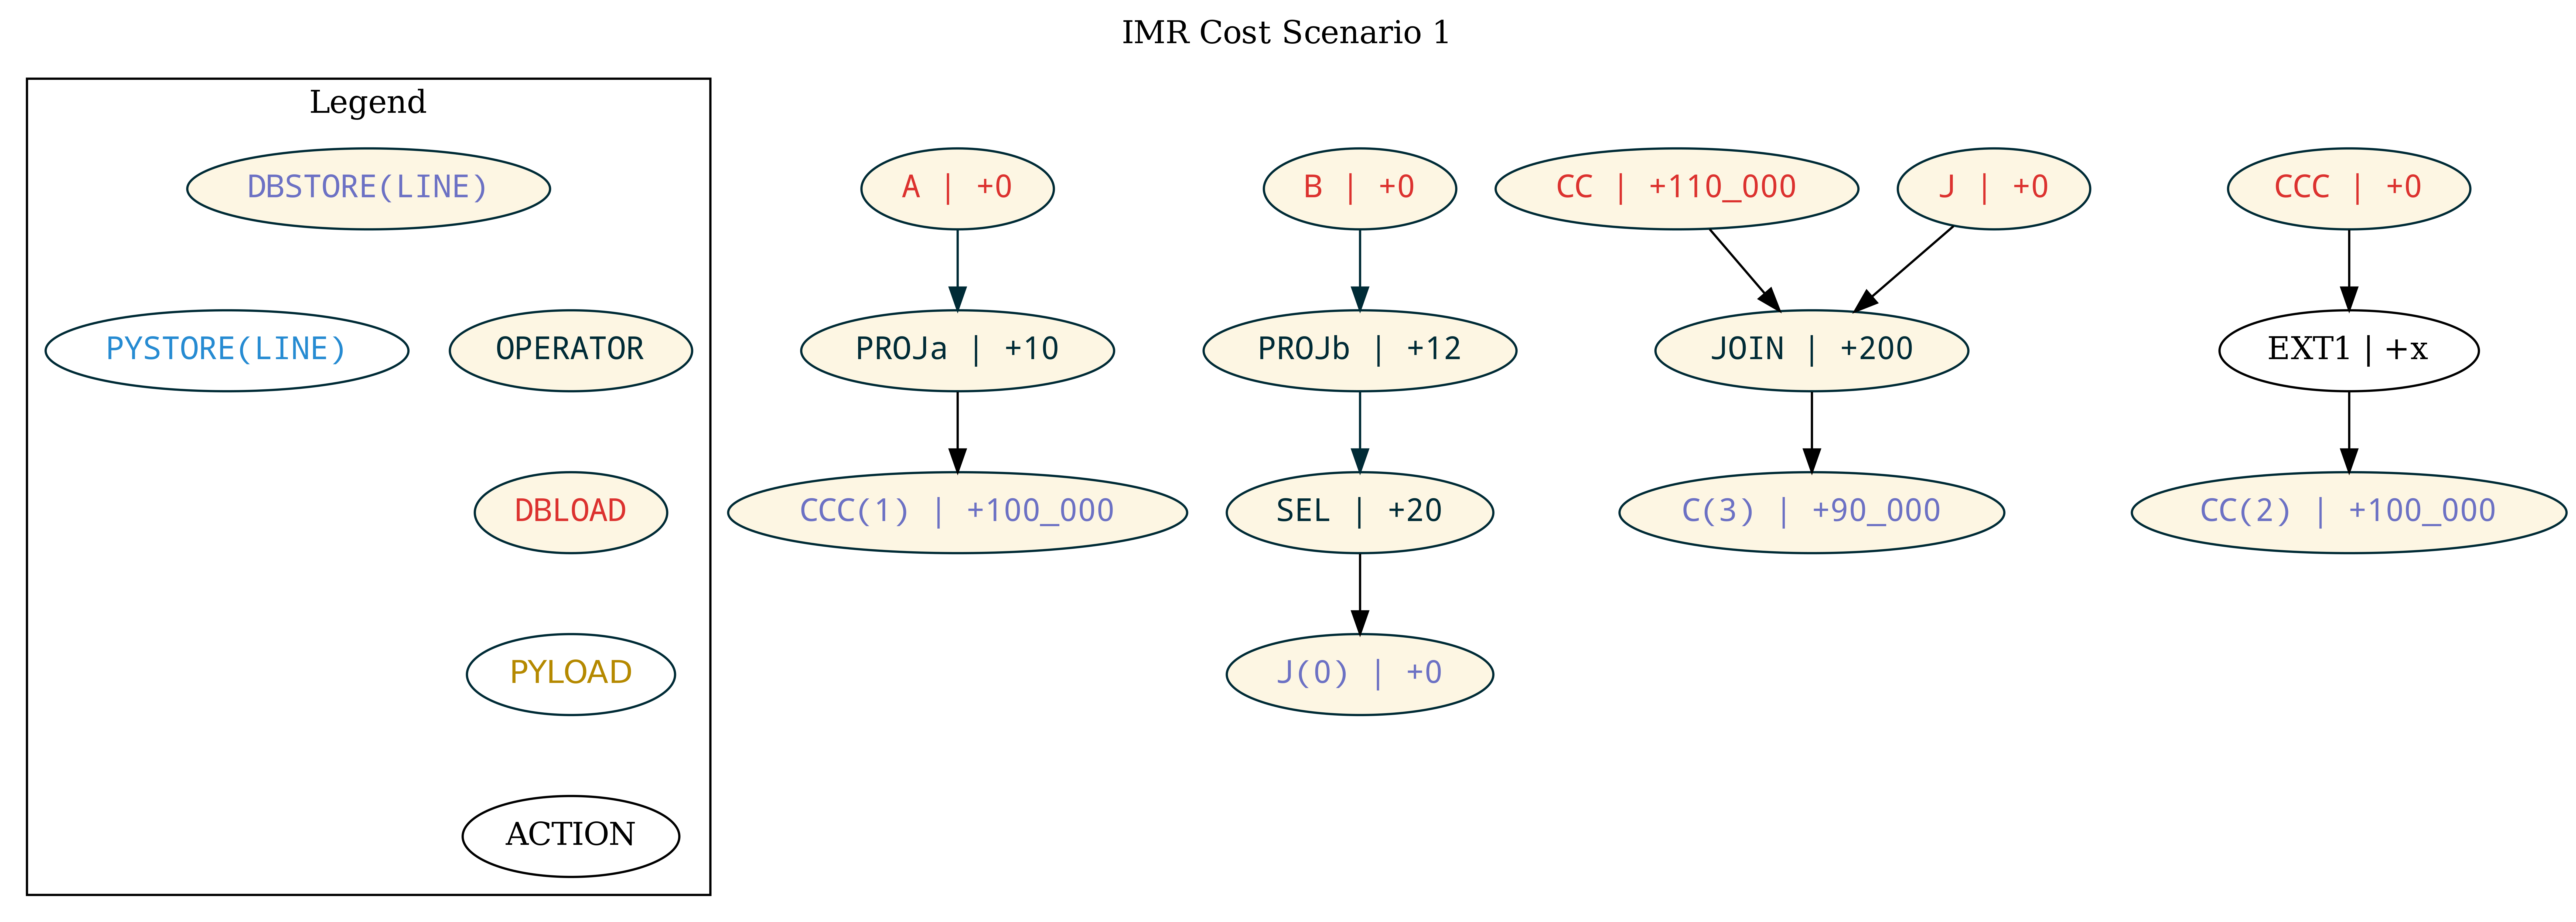

In [25]:
COST1=copy.deepcopy(PRUNE)
COST1.graph['label']='IMR Cost Scenario 1'
# COST1.remove_node('C(3)')
# COST1.add_node('C(3)', **PYSTORE)
# COST1.add_edge('JOIN','C(3)')

# COST1.remove_node('CC')
# COST1.add_node('CC', **DBLOAD)
# COST1.add_edge('CC', 'EXT1')

# COST1.remove_node('CCC')
# COST1.add_node('CCC', **DBLOAD)
# COST1.add_edge('CCC', 'JOIN')

#Symbols PROJ SEL ρ JOIN θ ⋉ ⋊ ▷
mapping = {'A':'A | +0', 'B':'B | +0','PROJa': "PROJa | +10",'PROJb': "PROJb | +12", "CC(2)": "CC(2) | +100_000","CCC(1)": "CCC(1) | +100_000","CC": "CC | +110_000", "C(3)": "C(3) | +90_000", "SEL": 'SEL | +20', 'JOIN':'JOIN | +200',
          'EXT1': 'EXT1 | +x', 'CCC': 'CCC | +0', 'J':'J | +0', 'J(0)':'J(0) | +0'}
COST1 = nx.relabel_nodes(COST1, mapping)

showgraph(COST1, costlegend, width=1200)

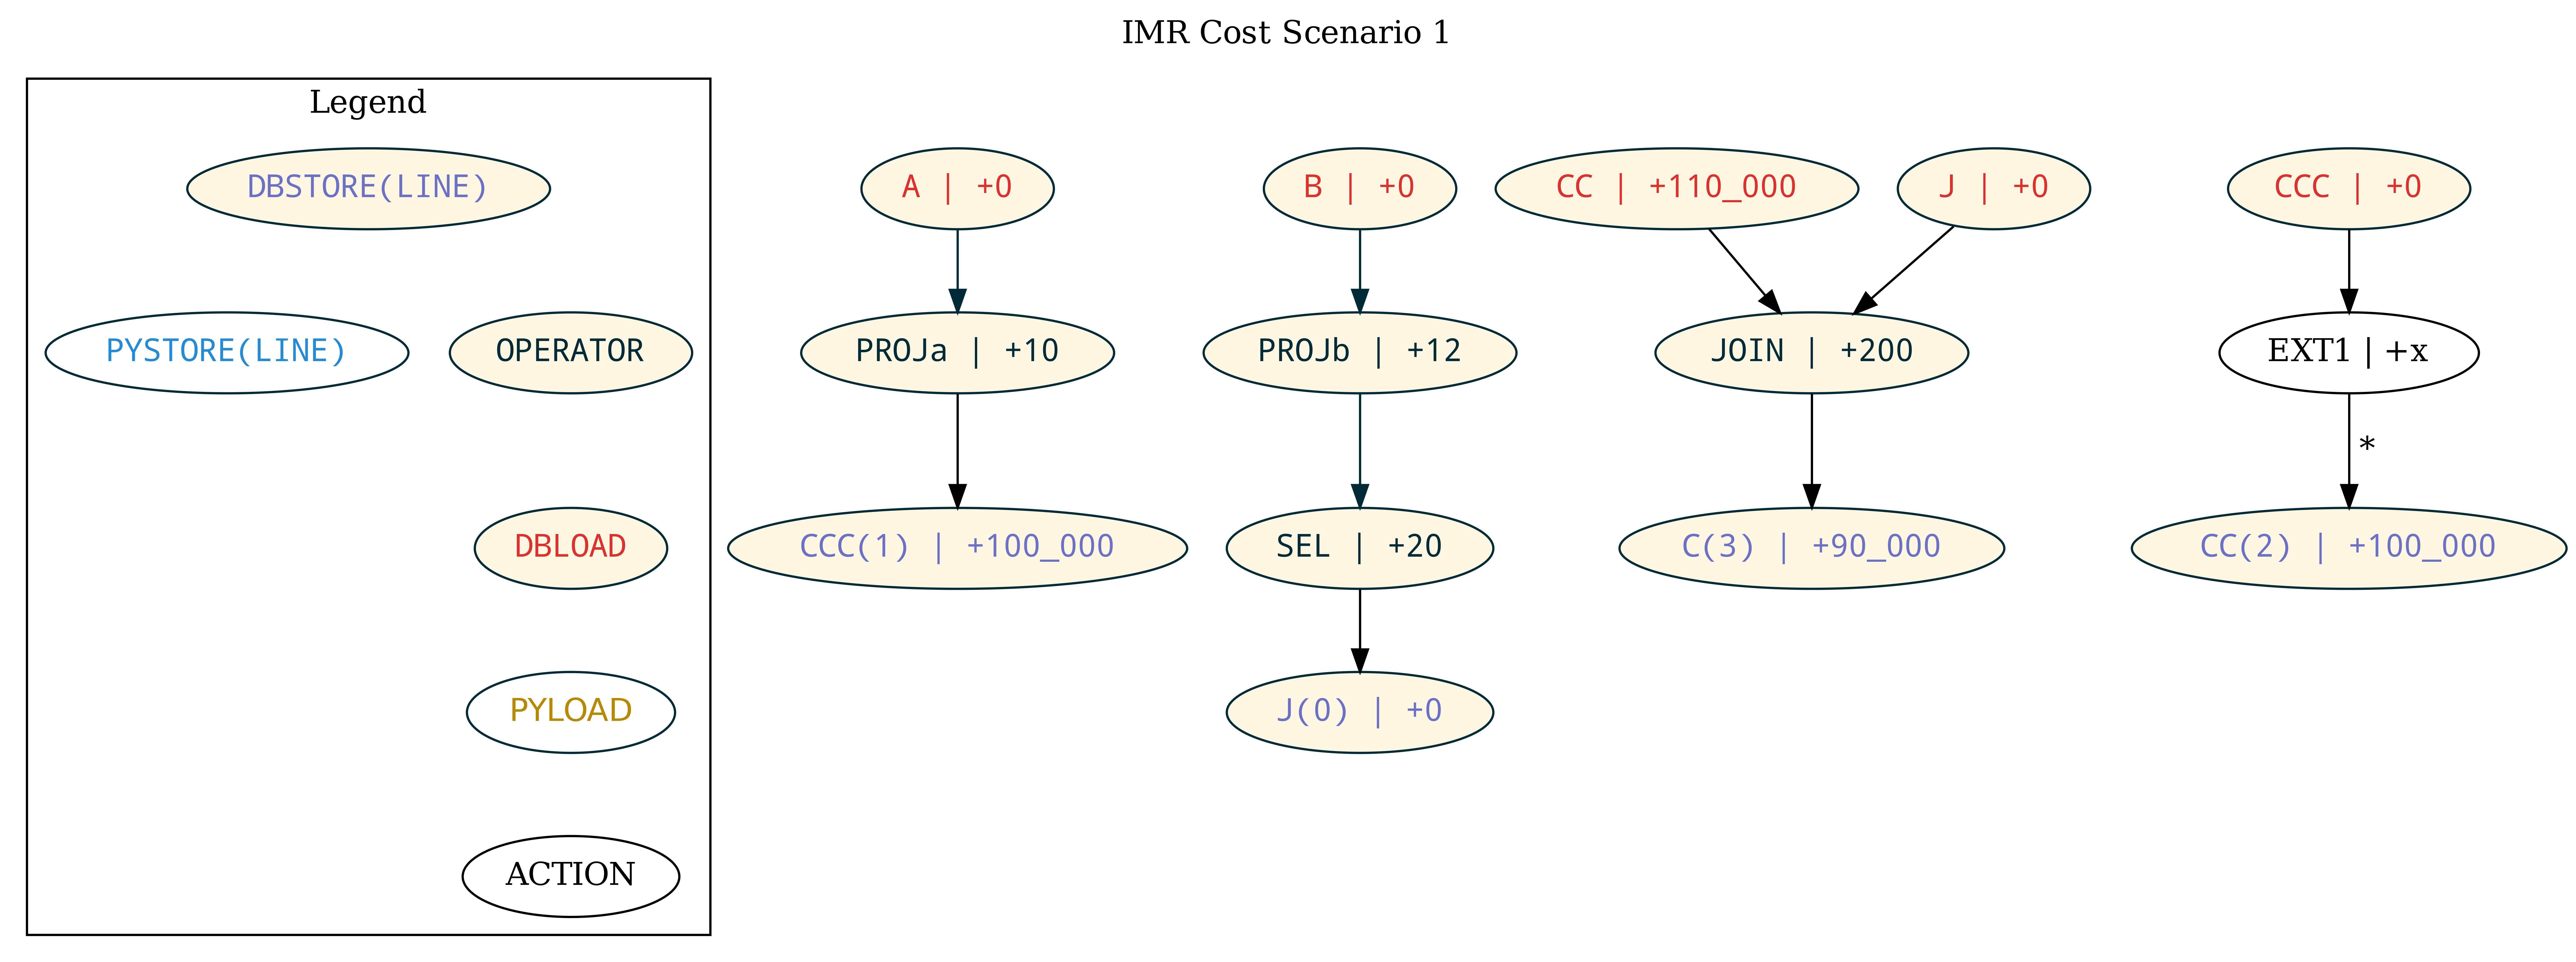

In [26]:
COST1['EXT1 | +x']['CC(2) | +100_000']['label']=' *'
showgraph(COST1, costlegend, width=1200)

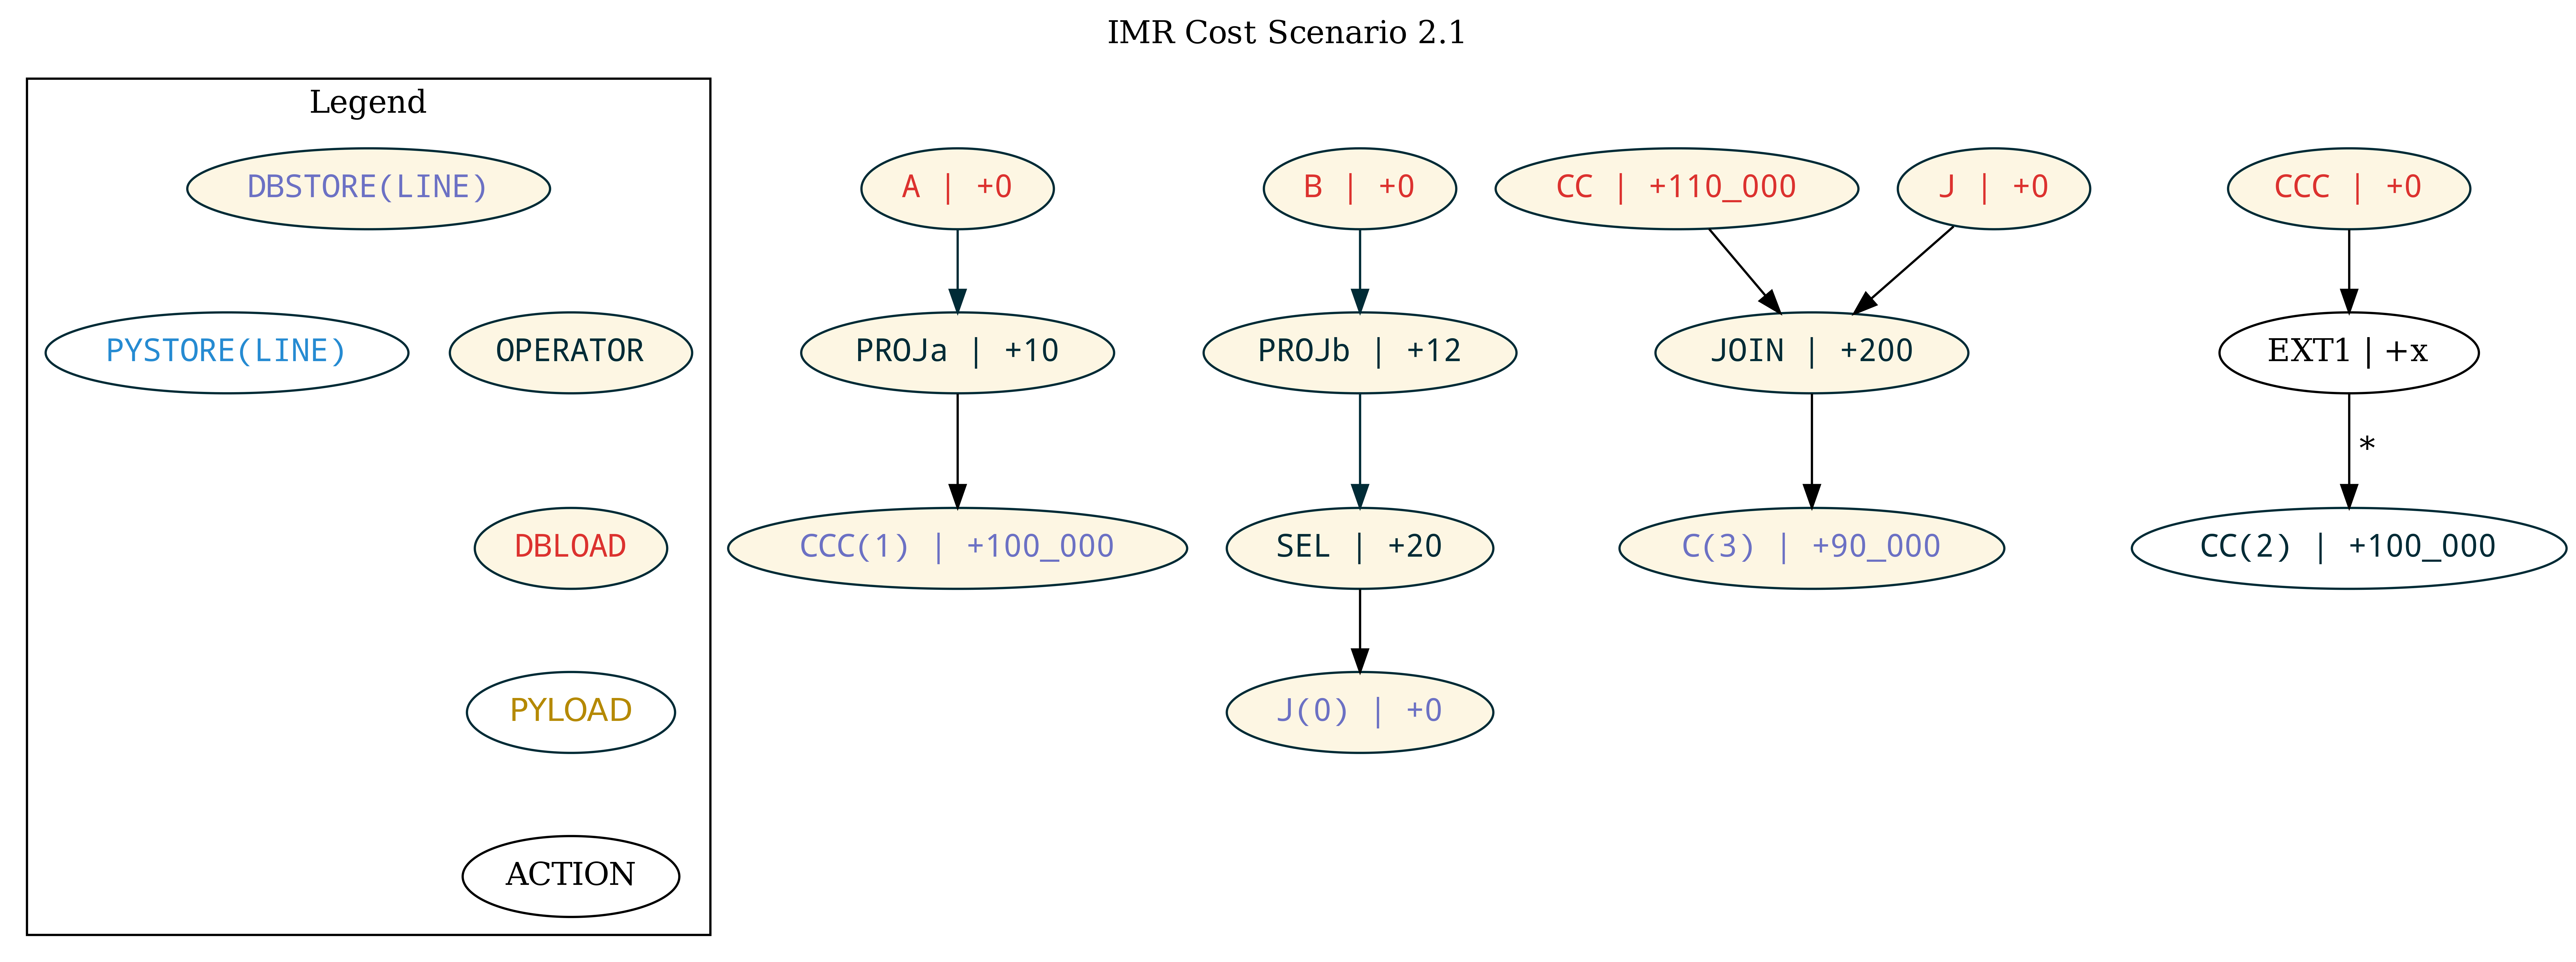

In [28]:
COST2=copy.deepcopy(COST1)
COST2.graph['label']='IMR Cost Scenario 2.1'
TO(COST2.nodes['CC(2) | +100_000'], ACTION)
#COST2['CCC | +0']['JOIN | +200']['label']=' *'

showgraph(COST2, costlegend, width=1200)

In [29]:
COST22=copy.deepcopy(COST2)
COST22.graph['label']='IMR Cost Scenario 2.2'
TO(COST22.nodes['JOIN | +200'], ACTION)
del COST22['CCC | +0']['JOIN | +200']['label']
COST22['SEL | +20']['JOIN | +200']['label']=' *'
showgraph(COST22, costlegend, width=1200)

KeyError: 'JOIN | +200'